In [364]:
import ssdeep
import pickle,os,sys,gc
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from tqdm import tqdm
from collections import Counter
import multiprocessing as mp
from multiprocessing import Process, Manager, Pool
import time,datetime
from itertools import chain
import math
from operator import itemgetter
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import jaccard_score
from sklearn.metrics.pairwise import cosine_similarity
import functools
import itertools
import operator

In [147]:
#  import sys,os
print(sys.executable)
print(sys.version)
print(sys.version_info)
import findspark
# os.environ['PYSPARK_PYTHON'] = '/usr/bin/python3' #'/home/antslab/anaconda3/bin/python'
findspark.init()
import pyspark
# from pyspark import SparkContext
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import Row, SQLContext, SparkSession, window
from pyspark import SparkConf, SparkContext
# Import data types
from pyspark.sql.types import *
import  pyspark.sql.functions as F
conf = SparkConf()
# conf.set("spark.local.dir", "/mnt/ssd240g/data/Leo_Spark_Home/tmp")
conf.set("spark.executor.cores","12")
conf.setMaster("local[12]")
conf.set("spark.driver.memory","85g")
conf.set("spark.executor.memory", "95g")
conf.set("spark.memory.offHeap.enabled","true")
conf.set("spark.memory.offHeap.size","85g")
conf.set("spark.driver.extraJavaOptions","-Xss80g")
conf.set("spark.driver.extraJavaOptions","-Xms80g")
# conf.set("spark.memory.storageFraction","0.2")
# conf.set("spark.driver.maxResultSize","0")
# conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
# conf.set("spark.sql.execution.arrow.enabled", "true")
conf.set("spark.kubernetes.pyspark.pythonVersion","3")
conf.set("spark.sql.shuffle.partitions",100000)
conf.set("spark.driver.maxResultSize", "150g")

# spark = SparkSession.builder.appName("pcap_analyzer").config(conf=conf).getOrCreate() #pcap_analyzer pcapAnalyzer
spark = SparkSession.builder.master("local").appName("Test_spark").config(conf=conf).getOrCreate()
# spark.conf.set("spark.sql.execution.arrow.enabled", True)
spark.conf.set("spark.sql.debug.maxToStringFields", 290000)
spark.conf.set("spark.sql.hive.filesourcePartitionFileCacheSize",100*1024*1024*1024)

import databricks.koalas as ks
ks.options.display.max_rows = 20
ks.set_option('compute.max_rows', None)
# ks.set_option('compute.ops_on_diff_frames', True)
ks.set_option('compute.default_index_type', 'distributed')
print(ks.__version__)
spark.version

/home/antslab/anaconda3/bin/python
3.7.7 (default, Mar 26 2020, 15:48:22) 
[GCC 7.3.0]
sys.version_info(major=3, minor=7, micro=7, releaselevel='final', serial=0)
1.0.1


'3.0.0'

In [148]:
in_file = "/home/antslab/data_hdd4t/pcap_process/pcap_spark/2020_01_10/中華電信/parquet/2020_01_10_session_v7-2_hashpayload_time_size.parquet"
pickle_dir = '/home/antslab/spark_data/pcap_inter/2020_01_10/中華電信/case_pickles/'
picture_dir = '/home/antslab/spark_data/pcap_inter/2020_01_10/中華電信/case_pictures/'

In [149]:
if not os.path.exists(pickle_dir):
    os.makedirs(pickle_dir,exist_ok=True)
if not os.path.exists(picture_dir):
    os.makedirs(picture_dir,exist_ok=True)    
df = ks.read_parquet(in_file)
print(df.columns)
df = df[['session_time','session_time_list','session_duration','session_tt_packet', 'session_i_tt_packet', 'session_o_tt_packet',
             'session_tt_frame_length', 'session_i_tt_frame_length','session_o_tt_frame_length','udp_tt_length', 'udp_i_tt_length',
             'udp_o_tt_length', 'udp_i_avg_length', 'udp_o_avg_length','icmp_i_avg_length', 'icmp_o_avg_length',
             'icmp_tt_original_datagram_length', 'icmp_i_tt_datagram_length','icmp_o_tt_datagram_length', 'icmp_i_avg_datagram_length',
             'icmp_o_avg_datagram_length','tcp_tt_payload_length', 'tcp_i_tt_payload_length','tcp_o_tt_payload_length', 'tcp_i_avg_payload_length',
             'tcp_o_avg_payload_length','ip_src', 'ip_dst','tcp_srcport', 'tcp_dstport', 'udp_srcport', 'udp_dstport', 'country',
             'city', 'subdivisions','domain','isp','frame_i_common_protocols','frame_o_common_protocols', 'frame_i_max_protocols','frame_o_max_protocols', 'tcp_i_payload_list', 'tcp_o_payload_list'        
            ]]
# df['tcp_payload_avg'] = df.tcp_payload_size/df.session_packets
# df['udp_payload_size'] = df.udp_length_sum - (df.session_packets*8)
# df['udp_payload_avg'] = df.udp_payload_size/df.session_packets
# df['icmp_payload_avg'] = df.icmp_length_original_datagram_sum/df.session_packets

 #50461592 
gc.collect()
# df

Index(['session_time', 'session_time_list', 'session_duration',
       'session_tt_packet', 'session_i_tt_packet', 'session_o_tt_packet',
       'session_tt_frame_length', 'session_i_tt_frame_length',
       'session_o_tt_frame_length', 'udp_tt_length', 'udp_i_tt_length',
       'udp_o_tt_length', 'udp_i_avg_length', 'udp_o_avg_length',
       'icmp_tt_length', 'icmp_i_tt_length', 'icmp_o_tt_length',
       'icmp_i_avg_length', 'icmp_o_avg_length',
       'icmp_tt_original_datagram_length', 'icmp_i_tt_datagram_length',
       'icmp_o_tt_datagram_length', 'icmp_i_avg_datagram_length',
       'icmp_o_avg_datagram_length', 'tcp_hdr_len_sum',
       'tcp_tt_payload_length', 'tcp_i_tt_payload_length',
       'tcp_o_tt_payload_length', 'tcp_i_avg_payload_length',
       'tcp_o_avg_payload_length', 'ip_avg_ttl', 'ip_max_ttl',
       'tcp_avg_window', 'tcp_max_window', 'ip_src', 'ip_dst', 'ip_proto',
       'tcp_srcport', 'tcp_dstport', 'udp_srcport', 'udp_dstport', 'country',
       'city', '

1589

In [150]:
 #篩選出有in bound payload的session
df1 = df[(df.session_duration>0.1)&(df.session_i_tt_packet>1)&(df.session_i_tt_frame_length>0)&
         (df.tcp_i_payload_list.astype(str)!='[]')]
df1 = df1[(df1.udp_i_tt_length>0)|(df1.udp_i_avg_length>0)|(df1.icmp_i_avg_length>0)|
        (df1.icmp_i_tt_datagram_length>0)|(df1.tcp_i_tt_payload_length>0)|(df1.tcp_i_avg_payload_length>0)]
gc.collect()
# df1

960

In [151]:
df2 = df1[(df1.tcp_o_payload_list.astype(str)!='[]')&(df1.session_o_tt_packet>0)&(df1.session_o_tt_frame_length>0)]
df2 = df2[(df2.udp_o_tt_length>0)|(df2.udp_o_avg_length>0)|(df2.icmp_o_avg_length>0)|
        (df2.icmp_o_tt_datagram_length>0)|(df2.tcp_o_tt_payload_length>0)|(df2.tcp_o_avg_payload_length>0)]
df2 = df2[(df2.domain != 'googlebot.com')|(df2.isp!='Googlebot')]
gc.collect()
df2 = df2.to_pandas()
df2

session_time                                  session_time_list  \
0             1.578643e+09  [1578643197.276759, 1578643197.277064, 1578643...   
1             1.578658e+09  [1578657587.412758, 1578657587.412969, 1578657...   
2             1.578668e+09  [1578668067.012655, 1578668067.012826, 1578668...   
3             1.578668e+09  [1578668053.538169, 1578668053.538542, 1578668...   
4             1.578610e+09  [1578609567.35313, 1578609567.353408, 15786095...   
...                    ...                                                ...   
850403556469  1.578632e+09  [1578632491.541228, 1578632491.541396, 1578632...   
850403556470  1.578665e+09  [1578664857.277239, 1578664857.277441, 1578664...   
850403556471  1.578646e+09  [1578645900.600578, 1578645900.600778, 1578645...   
850403556472  1.578590e+09  [1578590451.954192, 1578590451.95451, 15785904...   
850403556473  1.578591e+09  [1578591255.107845, 1578591255.10814, 15785912...   

              session_duration  session_tt_packet  session_i_tt_packet  \
0                     0.750199                 18                    8   
1                    12.336481                 11                    6   
2                     0.118949                 10                    5   
3                     0.285563                 10                    5   
4                    81.360489                 13                    7   
...                        ...                ...                  ...   
850403556469        121.793877                 16                    8   
850403556470        122.062119                 18                    8   
850403556471          1.033824                 12                    6   
850403556472          1.074809                 16                    8   
850403556473          2.880913                400                   85   

              session_o_tt_packet  session_tt_frame_length  \
0                              10                     1845   
1                               5                     1388   
2                               5                      802   
3                               5                      801   
4                               6                     1360   
...                           ...                      ...   
850403556469                    8                     1508   
850403556470                   10                     1628   
850403556471                    6                     1015   
850403556472                    8                     2319   
850403556473                  315                  2049441   

              session_i_tt_frame_length  session_o_tt_frame_length  \
0                                   899                        946   
1                                   615                        773   
2                                   418                        384   
3                                   417                        384   
4                                   589                        771   
...                                 ...                        ...   
850403556469                        808                        700   
850403556470                        808                        820   
850403556471                        557                        458   
850403556472                       1214                       1105   
850403556473                       5913                    2043528   

              udp_tt_length  udp_i_tt_length  udp_o_tt_length  \
0                       NaN              NaN              NaN   
1                       NaN              NaN              NaN   
2                       NaN              NaN              NaN   
3                       NaN              NaN              NaN   
4                       NaN              NaN              NaN   
...                     ...              ...              ...   
850403556469            NaN              NaN              NaN   
850403556470            NaN              NaN  

In [152]:
print("所有protocol總和中，1.原本的session總數:",len(df)," 2.in-bound具有payload的sessiony總數:",len(df1)," 3.in-與out-bound都具有payload的session總數(最終拿來進行分群的sessions):",len(df2))

所有protocol總和中，1.原本的session總數: 50461592  2.in-bound具有payload的sessiony總數: 13649714  3.in-與out-bound都具有payload的session總數(最終拿來進行分群的sessions): 3178444


In [153]:
print(df2.frame_i_max_protocols.value_counts().head(60))
print(df2.frame_o_max_protocols.value_counts().head(60))
print(df2.domain.value_counts().head(60))
df2.isp.value_counts().head(60)

eth:ethertype:ip:tcp:tds:gss-api                        1859199
eth:ethertype:ip:tcp:ssh                                 386331
eth:ethertype:ip:tcp:tds                                 367564
eth:ethertype:ip:tcp:nbss:smb                            263956
eth:ethertype:ip:tcp:http                                 97161
eth:ethertype:ip:tcp:nbss:smb:gss-api:spnego:ntlmssp      64889
eth:ethertype:ip:tcp:data                                 36716
eth:ethertype:ip:tcp:http:urlencoded-form                 20385
eth:ethertype:ip:tcp:smtp                                 14255
eth:ethertype:ip:tcp:nbss:smb:ntlmssp                     13463
eth:ethertype:ip:tcp:ssl                                  10262
eth:ethertype:ip:tcp                                       8696
eth:ethertype:ip:tcp:ftp                                   7672
eth:ethertype:ip:tcp:sip                                   5190
eth:ethertype:ip:tcp:nbss:smb2                             4394
eth:ethertype:ip:tcp:nbss:smb:dcerpc    

hinet.net                        603778
linkone.co.kr                    116419
contabo.net                      106260
cantv.net                         60647
airtelbroadband.in                48559
actcorp.in                        35757
viettel.vn                        31954
telbrax.net.br                    26292
webflash.net.br                   23655
dss-group.net                     22260
vnpt.vn                           20999
axtel.net                         18252
corbina.ru                        17127
tedata.net                        14008
asianet.co.th                     13291
ip-193-70-6.eu                    13004
ip-94-23-145.eu                   12130
123-tataidc.co.in                 10769
linode.com                         9872
turbonex.com.br                    8409
ip-139-99-113.net                  8275
sikkanet.com                       4951
ip-5-135-73.eu                     4743
prod-infinitum.com.mx              4612
magticom.ge                        4453


HiNet                                              1249335
Sejong Telecom                                      116420
Contabo GmbH                                        106377
OVH SAS                                              86841
BSNL                                                 85082
Viettel Group                                        80327
PT Telkom Indonesia                                  77563
FPT Telecom Company                                  71282
Cantv                                                61205
Directweb Tecnologia em Informatica Eireli           55636
China Mobile Guangdong                               54834
China Unicom Shanghai                                50463
Airtel Broadband                                     48559
ACT Fibernet                                         35825
Telstra Internet                                     30130
Hostkey B.v.                                         30064
Tencent cloud computing                              295

In [188]:
# case protocol study
ip_li = ['5.188.211.35','5.188.210.65','213.87.148.112','172.80.253.50','203.150.154.191',
         '149.129.50.37','106.12.69.27','109.169.21.204','195.154.200.161','94.23.20.187',
         '200.255.122.170','173.82.105.53']
for ip in ip_li:
    print(ip,':',df[df.ip_src == ip].frame_i_max_protocols.unique().to_numpy())

5.188.211.35 : ['eth:ethertype:ip:tcp' 'eth:ethertype:ip:tcp:http:urlencoded-form'
 'eth:ethertype:ip:tcp:http']
5.188.210.65 : ['eth:ethertype:ip:tcp:http' 'eth:ethertype:ip:tcp'
 'eth:ethertype:ip:tcp:http:urlencoded-form']
213.87.148.112 : ['eth:ethertype:ip:tcp:http']
172.80.253.50 : ['eth:ethertype:ip:tcp:http:data' 'eth:ethertype:ip:icmp:data'
 'eth:ethertype:ip:tcp:http:urlencoded-form' 'eth:ethertype:ip:tcp']
203.150.154.191 : ['eth:ethertype:ip:tcp:http' 'eth:ethertype:ip:tcp']
149.129.50.37 : ['eth:ethertype:ip:tcp' 'eth:ethertype:ip:tcp:http']
106.12.69.27 : ['eth:ethertype:ip:tcp' 'eth:ethertype:ip:tcp:http'
 'eth:ethertype:ip:tcp:http:data'
 'eth:ethertype:ip:tcp:http:urlencoded-form:data'
 'eth:ethertype:ip:tcp:http:urlencoded-form']
109.169.21.204 : ['eth:ethertype:ip:tcp:http:data' 'eth:ethertype:ip:tcp']
195.154.200.161 : ['eth:ethertype:ip:tcp:mysql' 'eth:ethertype:ip:tcp:http']
94.23.20.187 : ['eth:ethertype:ip:tcp:ftp' 'eth:ethertype:ip:tcp'
 'eth:ethertype:ip:tcp:h

In [317]:
case_df = df2[(df2.ip_src == '106.12.69.27')&(df2.frame_i_max_protocols.str.contains('http'))]
time_li = case_df.session_time_list.tolist()
time_li = [list(x) for x in time_li]
pickle.dump(obj=time_li,file=open(pickle_dir+"106.12.69.27_timelist_http.pkl",'wb'))
print(len(time_li))
case_df

10


session_time                                  session_time_list  \
6053965   1.578627e+09  [1578627055.842613, 1578627055.842792, 1578627...   
14382311  1.578626e+09  [1578625637.9666, 1578625637.968579, 157862563...   
20692536  1.578617e+09  [1578617358.452822, 1578617358.453095, 1578617...   
23466138  1.578595e+09  [1578594918.125719, 1578594918.125985, 1578594...   
35581929  1.578591e+09  [1578591113.808755, 1578591113.809026, 1578591...   
37348229  1.578586e+09  [1578585754.264546, 1578585754.264699, 1578585...   
41384865  1.578651e+09  [1578650789.10534, 1578650789.105647, 15786507...   
45423724  1.578610e+09  [1578609863.429914, 1578609863.430133, 1578609...   
46179851  1.578606e+09  [1578606449.788336, 1578606449.788553, 1578606...   
46934166  1.578655e+09  [1578654646.513111, 1578654646.513304, 1578654...   

          session_duration  session_tt_packet  session_i_tt_packet  \
6053965           0.170523                 10                    6   
14382311          0.959912                 10                    5   
20692536         24.911304                 14                    8   
23466138          0.194254                 10                    5   
35581929          0.480692                 11                    6   
37348229          1.310619                 11                    6   
41384865         11.525888                 18                   12   
45423724          0.778845                 11                    6   
46179851          0.859199                 14                    7   
46934166         16.448891                 16                   11   

          session_o_tt_packet  session_tt_frame_length  \
6053965                     4                     1280   
14382311                    5                     1431   
20692536                    6                    15970   
23466138                    5                     1520   
35581929                    5                     1335   
37348229                    5                     1710   
41384865                    6                    16122   
45423724                    5                     1596   
46179851                    7                    15918   
46934166                    5                     3903   

          session_i_tt_frame_length  session_o_tt_frame_length  udp_tt_length  \
6053965                       562.0                      718.0            NaN   
14382311                     1027.0                      404.0            NaN   
20692536                     1086.0                    14884.0            NaN   
23466138                     1116.0                      404.0            NaN   
35581929                      551.0                      784.0            NaN   
37348229                      926.0                      784.0            NaN   
41384865                     1238.0                    14884.0            NaN   
45423724                      812.0                      784.0            NaN   
46179851                      968.0                    14950.0            NaN   
46934166                     3102.0                      801.0            NaN   

          udp_i_tt_length  udp_o_tt_length  udp_i_avg_length  \
6053965               NaN              NaN               NaN   
14382311              NaN              NaN               NaN   
20692536              NaN              NaN               NaN   
23466138              NaN              NaN               NaN   
35581929              NaN              NaN               NaN   
37348229              NaN              NaN               NaN   
41384865              NaN              NaN               NaN   
45423724              NaN              NaN               NaN   
46179851              NaN              NaN               NaN   
46934166              NaN              NaN               NaN   

          udp_o_avg_length  icmp_i_avg_length  icmp_o_avg_length  \
6053965                NaN                NaN                NaN   
14382311           

In [154]:
protocol_name = 'tds'
df2_tds = df2[(df2.frame_i_max_protocols.str.contains(protocol_name))&(df2.frame_o_max_protocols.str.contains(protocol_name))]
df2_tds

session_time                                  session_time_list  \
12            1.578638e+09  [1578638222.544299, 1578638222.54455, 15786382...   
13            1.578635e+09  [1578635129.809907, 1578635129.810109, 1578635...   
14            1.578635e+09  [1578634893.782309, 1578634893.782594, 1578634...   
15            1.578632e+09  [1578631575.778327, 1578631575.778545, 1578631...   
16            1.578633e+09  [1578633232.497241, 1578633232.497412, 1578633...   
...                    ...                                                ...   
850403556461  1.578651e+09  [1578650834.504234, 1578650834.504426, 1578650...   
850403556464  1.578664e+09  [1578663700.603665, 1578663700.603803, 1578663...   
850403556466  1.578660e+09  [1578659737.888337, 1578659737.888471, 1578659...   
850403556467  1.578660e+09  [1578659689.259777, 1578659689.261021, 1578659...   
850403556468  1.578660e+09  [1578659552.741931, 1578659552.742169, 1578659...   

              session_duration  session_tt_packet  session_i_tt_packet  \
12                    0.890478                  8                    5   
13                    0.794191                 10                    6   
14                    0.741235                  8                    5   
15                    0.293953                  9                    5   
16                    1.621422                  8                    5   
...                        ...                ...                  ...   
850403556461          2.019776                  8                    5   
850403556464        120.905128                 18                    9   
850403556466          3.068789                  8                    5   
850403556467          3.116079                  8                    5   
850403556468          3.814021                  8                    5   

              session_o_tt_packet  session_tt_frame_length  \
12                              3                      730   
13                              4                      924   
14                              3                      734   
15                              4                      768   
16                              3                      730   
...                           ...                      ...   
850403556461                    3                      722   
850403556464                    9                     1650   
850403556466                    3                      722   
850403556467                    3                      732   
850403556468                    3                      726   

              session_i_tt_frame_length  session_o_tt_frame_length  \
12                                  482                        248   
13                                  542                        382   
14                                  480                        254   
15                                  454                        314   
16                                  476                        254   
...                                 ...                        ...   
850403556461                        474                        248   
850403556464                       1042                        608   
850403556466                        474                        248   
850403556467                        478                        254   
850403556468                        478                        248   

              udp_tt_length  udp_i_tt_length  udp_o_tt_length  \
12                      NaN              NaN              NaN   
13                      NaN              NaN              NaN   
14                      NaN              NaN              NaN   
15                      NaN              NaN              NaN   
16                      NaN              NaN              NaN   
...                     ...              ...              ...   
850403556461            NaN              NaN              NaN   
850403556464            NaN              NaN  

### Function

In [155]:
 
def prepare_df(df2,protocol_name='http',split="size",loner=False):
    protocol_name = str(protocol_name).lower()
    '''
    df2: filterout no payload's all sessions df
    protocol_name: what TCP protocol string would be contained e.g., smb,http,tds...
    loner: 用來檢查不同天相同protocol的分群
    
    return1: protocol original dataframe (session-based)
    return2: protocol payload dataframe (packet-based)
    '''
    def sort_fn(data):
        '''
        sort by time: itemgetter(1)
        sort by size: itemgetter(2)
        '''
        if split=='size':
            return sorted(data,key=itemgetter(2))
        elif split == 'time':
            return sorted(data,key=itemgetter(1))
                    
    def split_col_len(session):
        '''
        input: list(session) of lists(packets) =>tuple=(hash,time)

        Return1: list of ssdeep length
        Return2: list of session's packets hashes
        '''
    #     for session in payload_li:
#         packet_payload = []
        packet_len = []
        for packet in session:
            ssdeep_hash = packet[0]
    #         packet_payload.append(ssdeep_hash)
            packet_len.append(ssdeep_hash.split(':')[0])
        return packet_len#,packet_payload

    def split_col_hash(session):
        '''
        input: list(session) of lists(packets) =>tuple=(hash,time)

        Return1: list of ssdeep length
        Return2: list of session's packets hashes
        '''
    #     for session in payload_li:
        packet_payload = []
#         packet_len = []
        for packet in session:
            ssdeep_hash = packet[0]
            packet_payload.append(ssdeep_hash)
    #         packet_len.append(ssdeep_hash.split(':')[0])
        return packet_payload
    if not loner:
        df2_protocol = df2[(df2.frame_i_max_protocols.str.contains(protocol_name))&(df2.frame_o_max_protocols.str.contains(protocol_name))]
    else:
        df2_protocol = df2
    df2_protocol_payload = df2_protocol[['tcp_i_payload_list']]
    df2_protocol_payload['tcp_i_payload_list'] = df2_protocol_payload.tcp_i_payload_list.map(sort_fn)
    df2_protocol_payload['size'] = df2_protocol_payload.tcp_i_payload_list.map(split_col_len) #,df2_protocol_payload['hash']
    df2_protocol_payload['hash'] = df2_protocol_payload.tcp_i_payload_list.map(split_col_hash)
    L_size = [x if isinstance(x, list) else [x] for x in df2_protocol_payload['size']]
    L_hash = [x if isinstance(x, list) else [x] for x in df2_protocol_payload['hash']]
    df2_protocol_payload = pd.DataFrame({
        'idx':df2_protocol_payload.index.values.repeat([len(x) for x in L_size]),
        'size':list(chain.from_iterable(L_size)),
        'hash':list(chain.from_iterable(L_hash))
        })
    # df2_protocol_payload['idx'] = 
    df2_protocol_payload['size'] = df2_protocol_payload['size'].astype(int)
    if not loner:
        return df2_protocol, df2_protocol_payload
    else:
        return df2_protocol_payload

In [156]:
def similarity_compare(df2_protocol,df2_protocol_payload,ori_protocol=None,ori_protocol_payload=None,thr=0,thr2=10,loner=False): #40
    '''
    GOAL: compare with timestamp's q1,q2,q3 to similar size packet. Pick max value for score.
    df2_protocol: protocol original dataframe (session-based)
    df2_protocol_payload: protocol payload dataframe (packet-based)
    loner:需指派ori_protocol、ori_protocol_payload
    
    Return: dictionary with each cluster 
    '''
    def ssdeep_compare(target_hash,candidate_df):
        '''
        Input1: string of hash
        Input2: dataframe of candidate
        '''
        def compare(candidate_hash):
            return ssdeep.compare(target_hash,candidate_hash)
        return candidate_df.hash.map(compare)
    big_dict_protocol = {}
    big_dict_protocol_score = {}
#     big_dict_protocol2 = {} #test
    used_idx_li = []
    all_scores = [] #test2
    for idx in tqdm(df2_protocol.index):
        if idx in used_idx_li:
            continue
        target = df2_protocol_payload[df2_protocol_payload.idx == idx]
        target = target.reset_index(drop=True)
        t_len = len(target)
        q1 = int(t_len*0.25)
        q2 = int(t_len*0.5)
        t_q1 = target.iloc[q1,-1]
        if not loner:
            candidate = df2_protocol_payload[df2_protocol_payload.idx!=idx]
            candidate = candidate[~candidate.idx.isin(used_idx_li)] #candidat不可重複分群
        else:
            t_ip = df2_protocol[df2_protocol.index == idx].ip_src.values[0]
            candidate_idx = ori_protocol[ori_protocol.ip_src == t_ip].index.tolist()
            candidate = ori_protocol_payload[ori_protocol_payload.idx.isin(candidate_idx)] #可重複分群?
        
        candidate['idx'] = candidate.idx.astype(str)
#         candidate_q1 = candidate[candidate['size']==target.iloc[q1,-2]] #rule
        candidate['q1'] = ssdeep_compare(t_q1,candidate) #rule:candidate_q1
        if q2 != q1:
            t_q2 = target.iloc[q2,-1]
            q3 = int(t_len*0.75)
#             candidate_q2 = candidate[candidate['size']==target.iloc[q2,-2]] #rule
            candidate['q2'] = ssdeep_compare(t_q2,candidate) #rule:candidate_q2
            if q3 != q2:
                t_q3 = target.iloc[q3,-1]
#                 candidate_q3 = candidate[candidate['size']==target.iloc[q3,-2]] #rule
                candidate['q3'] = ssdeep_compare(t_q3,candidate) #rule:candidate_q3
                if t_len>4:
#                     t_min = target.iloc[0,-1] 
#                     candidate['min'] = ssdeep_compare(t_min,candidate)
                    t_max = target.iloc[-1,-1]
                    candidate['max'] = ssdeep_compare(t_max,candidate)
                    
        candidate = candidate.drop(['size','hash'],axis=1)
        candidate['score'] = candidate.mean(axis=1) #max
        score_li = candidate.score.tolist() #test2
        candidate = candidate[candidate.score>thr] #相似度分數，數字越小速度愈快、數字越大越多群
        candidate['idx'] = candidate.idx.astype(int)
#         candidate2 = candidate[candidate.score<thr2] #test
        idx_li = list(set(candidate.idx.tolist()))
#         idx_li2 = list(set(candidate2.idx.tolist())) #test
        all_scores.extend(score_li) #test2
        if len(idx_li)>0:
            
            used_idx_li.extend(idx_li)
            used_idx_li.append(idx)
            if not loner:
                big_dict_protocol[idx] = idx_li
                big_dict_protocol_score[idx] = candidate.score.tolist()
            else:
                big_dict_protocol[t_ip+'_'+str(idx)] = idx_li
                big_dict_protocol_score[t_ip+'_'+str(idx)] = candidate.score.tolist()                
#         if len(idx_li2)>0: #test
#             big_dict_protocol2[idx] = idx_li2 # test
    return big_dict_protocol,sorted(list(set(df2_protocol.index)-set(used_idx_li))),all_scores,big_dict_protocol_score #test

In [157]:
def write2pkl(df2_protocol,big_dict,cluster_key,case_id,path=pickle_dir):
    '''
    GOAL: output 3-tuple to draw time diagram
    df2_protocol: original dataframe session-based
    big_dict: big_dict_protocol
    cluster_key: print by find_cluster function
    case_id: user defined to identify
    '''
    cluster_key = int(cluster_key)
#     print(big_dict[cluster_key])
    temp_li = big_dict[cluster_key][:]
#     print(temp_li)
    temp_li.append(cluster_key) #最後一個session才是key (target)，其他人(candidates)都是跟他(target)比
#     print(temp_li)
#     temp_li = temp_li2[:]
    case_diagram = df2_protocol.loc[list(set(temp_li))]
    time_lists = case_diagram.session_time_list.tolist()
    time_lists = [list(x) for x in time_lists]
    ips = case_diagram.ip_src.tolist()
    countries = case_diagram.country.tolist()
    print('Unique Country#:',len(set(countries)),"Unique IP#:",len(set(ips)),'Session#:',len(time_lists))
    # pickle_dir = '/home/antslab/spark_data/pcap_inter/2020_01_10/中華電信/case_pickles/'
    pickle.dump(obj=(time_lists,ips,countries),file=open(path+'case#'+str(case_id)+'_threetuples.pkl','wb'))        


In [158]:
def find_cluster(big_dict,idx):
    '''
    big_dict: big_dict_protocol
    idx: which idx want to find
    Return cluster id (big_dict"s key number')
    '''
    idx = int(idx)
    try:
        big_dict[idx] #KeyError
        return idx
    except KeyError:
        for k,v in big_dict.items():
            if idx in v:
                return k
                break

In [159]:
def cluster_stat(protocol_big_dict,protocol_df,proto,date,drawlog=False):
    """
    GOAL: output statistic of certain protocol
    input1: dict from similarity_compare
    inpit2: df from prepare_df
    """
    
    all_nums = []
    clus_id = []
    # all_num = 0
    for k,v in protocol_big_dict.items():
    #     all_nums.extend(v)
        all_nums.append(len(v))
        clus_id.append(k)
    #     all_num +=len(v)
    clus_num = len(all_nums)
    print("原本總共sessions#:",len(protocol_df))
    print("共有#sessions可分群:",sum(all_nums)+clus_num,"共有#lonerSessions:",len(protocol_df)-(sum(all_nums)+clus_num))
    print("可分為#群:",clus_num)
#     print(sum(all_nums)+len(all_nums),len(protocol_df)-(sum(all_nums)+len(all_nums)),len(protocol_df))
    protocol_stat_df = pd.DataFrame(all_nums,index=clus_id)
    protocol_stat_df[0] = protocol_stat_df[0]+1
    print("前五大的cluster key與對應之群集大小\n",protocol_stat_df[0].nlargest(5))
    print(protocol_stat_df.describe())
    protocol_stat_df  = pd.DataFrame(all_nums,index=[x for x in range(len(all_nums))])
    protocol_stat_df.hist(bins=100)
    plt.savefig(picture_dir+str(proto)+'_'+str(date)+'_clustersize_hist'+'.png', dpi=300, format='png')
    
    temp = dict(Counter(all_nums))
    temp = {k: v for k, v in sorted(temp.items(), key=lambda item: item[0])}
#     temp = sorted(all_nums,reverse=True)
    x_axis = [k for k in temp.keys()] #群中所含的數量
    y_axis = [v for v in temp.values()] #該數量共有幾群為此
    plt.figure(figsize=(30,20),dpi=300,linewidth = 1) # 圖片大小、折線寬度
    plt.plot(x_axis,y_axis,'o-',color = 'b', label=proto) #折現的型態、折現的顏色
#     plt.title(, x=0.5, y=1.03)
    plt.figtext(.5,.9,str(date)+" "+str(proto)+" cluster# of cluster's size",fontsize=30,ha='center')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel("cluster size", fontsize=25, labelpad = 15)
    plt.ylabel("cluster #", fontsize=25, labelpad = 20)
    # plt.ylim(0, 2500)
    # plt.legend(loc = "best", fontsize=20)
    plt.savefig(picture_dir+str(proto)+'_'+str(date)+'_clusternumber_line'+'.png', dpi=300, format='png')
    plt.show()    
    
#log diagram
    fig, ax = plt.subplots()
    ax.set_yscale('log')
    protocol_stat_df.hist(ax=ax, bins=100, bottom=0.1)
    plt.savefig(picture_dir+str(proto)+'_'+str(date)+'_clustersize_hist_log'+'.png', dpi=300, format='png')
    
    return len(protocol_df)-(sum(all_nums)+clus_num),protocol_stat_df.describe()

In [160]:
def cluster_rep_hash(proto_big_dict,proto_df_payload,proto_df,proto_loners,knee_point,date='0110',protocol='http'):
    '''
    GOAL: create each cluster's representaion ssdeep hash
    proto_df_payload: from prepare_df() function
    proto_big_dict: from similarity_compare() function
    proto_loners: loner idx list
    knee_point: from get_small_cluster() function
    date & protocol: user_defined cluster name
    
    Return: dict[cluster_name]: ssdeep hash
    '''
    upgma_dict = {}
    for key,value in proto_big_dict.items(): #cluster rep ssdeep
        target = proto_df_payload[proto_df_payload.idx == key]
        target = target.reset_index(drop=True)
        t_len = len(target)
        q2 = int(t_len*0.5)
        q2_hash = target.iloc[q2,-1]
        country = proto_df.loc[key,'country']
        ip = proto_df.loc[key,'ip_src']
        domain = proto_df.loc[key,'domain']
        if len(value)>knee_point:
            upgma_dict[str(protocol)+'_'+str(key)+'_'+str(date)+'_'+str(country)+'_'+str(domain)+'_'+str(ip)] = q2_hash
        else:
            upgma_dict[str(protocol)+'_S_'+str(key)+'_'+str(date)+'_'+str(country)+'_'+str(domain)+'_'+str(ip)] = q2_hash
    for key in proto_loners: #loner ssdeep
        target = proto_df_payload[proto_df_payload.idx == key]
        target = target.reset_index(drop=True)
        t_len = len(target)
        q2 = int(t_len*0.5)
        q2_hash = target.iloc[q2,-1]
        country = proto_df.loc[key,'country']
        ip = proto_df.loc[key,'ip_src']
        domain = proto_df.loc[key,'domain']
        upgma_dict[str(protocol)+'_L_'+str(key)+'_'+str(date)+'_'+str(country)+'_'+str(domain)+'_'+str(ip)] = q2_hash
    return upgma_dict



def pair_wise_score(upgma_dict):
    '''
    GOAL: calculate distance matrix by calculating paire-wise similarity score. 
    and pick upper triangle convert to list
    Input: from cluster_rep_hash() function
    ['cluster']: name
    ['ssdeep']: cluster's representation hash
    
    Return: df=>['c_ssdeep_li']:the hashes list compare to, ['score']:list of distances (upper-triangle, exclude self)
    '''
    def compare(target_hash,candidate_hash_li):
        score_li = []
        for c_hash in candidate_hash_li:
            score_li.append(100-ssdeep.compare(target_hash,c_hash)) #相似度滿分100，轉換成距離最近0
        return score_li
    used_idx = []
    def create_hash_li(t_hash):
        idx_set = set(upgma_df[upgma_df.ssdeep == t_hash].index)#[0]
        same_hash_li = sorted(list(idx_set - set(used_idx)))
        idx = same_hash_li[0]
        used_idx.append(idx)
        return upgma_df.loc[idx+1:]['ssdeep'].tolist()
    upgma_df = pd.DataFrame(upgma_dict.items(),columns=['cluster','ssdeep'])
    upgma_df['c_ssdeep_li'] = upgma_df.ssdeep.map(create_hash_li)
    upgma_df['score'] = upgma_df.apply(lambda x: compare(x.ssdeep, x.c_ssdeep_li), axis=1)
    return upgma_df



def draw_upgma(upgma_df,picture_dir=picture_dir,name='upgma'):
    '''
    GOAL: using upper triangle's distance to draw upgma
    Input: from pair_wise_score() function
    Output: diagram of UPGMA、Z info
    '''
    if not os.path.exists(picture_dir):
        os.makedirs(picture_dir,exist_ok=True) 
    score_li = upgma_df['score'].tolist()
    score_li = list(filter(None, score_li))
    score_li = sum(score_li,[])
    Z = linkage(score_li, 'average')
    fig = plt.figure(figsize=(60, 24)) #(25,10) #(5,2)
    # plt.savefig(fig)
    dn = dendrogram(Z,labels=upgma_df.cluster.tolist())
    plt.savefig(picture_dir+str(name)+'.png', dpi=600, format='png', bbox_inches='tight')
    return dn,Z

In [161]:
def knee_point(length_li,proto='http',date='0110',k=200):
    """
    每個list值所包含數量的變化量，也就是點的密集度變化量 (並非list自己本身值的變化量)
    length_li: 長度的list
    k: slope topK's knee points
    Return dict format (key is the answer)
    """
    length_dict = dict(Counter(length_li))
    sorted_dict = {k: v for k, v in sorted(length_dict.items(), key=lambda x: x[1])}
    all_items_num = sum(list(length_dict.values()))
#     for item in sorted_dict.items():
    all_keys = list(sorted_dict.keys())
    all_values = list(sorted_dict.values())
    slope_li = []
    for i in range(len(sorted_dict)):
        length1 = all_keys[i]
        try:
            length2 = all_keys[i+1]
        except IndexError:
            break
        value1 = sum(all_values[:i+1])
        value2 = sum(all_values[:i+2])
        slope = ((value2-value1)/all_items_num)/(length2-length1)
        slope_li.append(slope)
    change_rate_li = []
    for i in range(len(slope_li)):
        try:
            slope1 = slope_li[i]
            slope2 = slope_li[i+1]
        except IndexError:
            break
        change_rate_li.append(abs(slope2-slope1)) #陡變緩或是緩變陡的都一起算
    idx_li = sorted(range(len(change_rate_li)), key=lambda i: change_rate_li[i], reverse=True)[:k]
    return_dict = {}
    for idx in idx_li:
        return_dict[all_keys[idx+1]] = change_rate_li[idx]
    ##畫圖可再自行修改
    temp = sorted(length_li,reverse=True)
    x_axis = [x for x in range(len(temp))] #隨便給個編號當成X軸
    plt.figure(figsize=(30,20),dpi=300,linewidth = 1) # 圖片大小、折線寬度
    plt.plot(x_axis,temp,'o-',color = 'b', label=proto) #折現的型態、折現的顏色
#     plt.title(, x=0.5, y=1.03)
    plt.figtext(.5,.9,str(date)+" "+str(proto)+" clusters' size",fontsize=30,ha='center')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel("cluster ID", fontsize=25, labelpad = 15)
    plt.ylabel("session #", fontsize=25, labelpad = 20)
    # plt.ylim(0, 2500)
    # plt.legend(loc = "best", fontsize=20)
    plt.savefig(picture_dir+str(proto)+'_'+str(date)+'_clustersize_line'+'.png', dpi=300, format='png')
    plt.show()
    return pd.DataFrame.from_dict(return_dict,orient='index',columns=['knee_slope'])

In [162]:
def get_small_cluster(proto_big_dict,proto_loner_num,q1_num,proto,date):
    '''
    proto_big_dict: big dict from similarity_compare() func.
    proto_loner_num: the protocol's loner numbers
    q1_num: 25%'s members# from
    
    Return: how many lesser is small cluster to deal as loner  (dict's member num)
    '''
    proto_dict_len = {}
    for k,v in proto_big_dict.items():
        proto_dict_len[k] = len(v)+1
    temp = list(proto_dict_len.values())
    for i in range(proto_loner_num):
        temp.append(1)
    temp = sorted(temp,reverse=True)
    temp_df = knee_point(temp,proto=proto,date=date)
    temp_score = temp_df.index.tolist()
    try:
        if temp_df.index[0] <q1_num:
            return temp_df.index[0]-1
        else:
            for score in temp_score:
                if score <q1_num:
                    return int(score)-1 #往後找其他knee point要小於q1
            return 0 #都不合<q1
    except IndexError:
        return 0 #群太少人太小分不出knee point

In [163]:
def case_cluster_info(protocol_loners,protocol_big_dict,protocol_df,proto='http',df2=df2):
    '''
    GOAL: output loner & each cluster's three tuples pickles.
    save file in pickle_dir+protol/ dir
    
    protocol_loners: from similarity_compare() func.
    protocol_big_dict: from similarity_compare() func.
    proto: now using what kind of protocol
    df2: payload whole df
    '''
    loner_df = df2.loc[protocol_loners]
    time_lists = loner_df.session_time_list.tolist()
    time_lists = [list(x) for x in time_lists]
    ips = loner_df.ip_src.tolist()
    countries = loner_df.country.tolist()
    pkl_dir = pickle_dir+proto+'/'
    if not os.path.exists(pkl_dir):
        os.makedirs(pkl_dir)
    pickle.dump(obj=(time_lists,ips,countries),file=open(pkl_dir+'case#loners'+'_threetuples.pkl','wb'))
    #cluster
    protocol_big_dict = {k: v for k, v in sorted(protocol_big_dict.items(), key=lambda item: len(item[1]),reverse=True)}
    for i,k in enumerate(protocol_big_dict.keys()):
        write2pkl(protocol_df,protocol_big_dict,k,str(i+1)+"_"+str(k),path=pkl_dir)
    return protocol_big_dict

run all protocols needed

In [181]:
# protocols_need = ['http','smb','telnet','ftp','smtp','mysql','ssh','ntp','rpc','imap','pop','ldap','vnc','sip'] #'http','smb','telnet','ftp','smtp','mysql','ssh','ntp','rpc',
#'http','smb','telnet','ftp','smtp','mysql','ssh','ntp','rpc','imap','pop','ldap','vnc','sip'
protocols_need = ['tds']
protocols_tuples = []

In [182]:
def run_all(proto,date): 
    '''
    proto: protocol contains for e.g., http
    date: day number e.g.,0110
    '''
    proto_df, proto_df_payload = prepare_df(df2,proto)
    proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict = similarity_compare(proto_df,proto_df_payload,thr=0)
    print("==========",str(proto)+" clusters ==========")
    try:
        proto_loner_num,stat_df = cluster_stat(proto_big_dict,proto_df,proto=proto,date=date)
        proto_big_dict = case_cluster_info(proto_loners,proto_big_dict,proto_df,proto=proto)
        small_clu_num = get_small_cluster(proto_big_dict,proto_loner_num,stat_df.loc['25%'].values[0],proto,date)
        print("===",str(proto),"loner threshold [small cluster / knee point]:",small_clu_num+1,"(include) ===")
        proto_upgma_dict = cluster_rep_hash(proto_big_dict,proto_df_payload,proto_df,proto_loners,knee_point=small_clu_num,date=date,protocol=proto)
        pickle.dump(obj=proto_upgma_dict,file=open(pickle_dir+str(proto)+'_upgma_dict_'+str(date)+'.pkl','wb'))
        pickle.dump(obj=(proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
                        proto_upgma_dict,stat_df),file=open(pickle_dir+str(date)+'_'+str(proto)+'_all.pkl','wb'))
    except KeyError:
        print("!!!Didn't save:",date,proto,"!!!")
        return ()
    return (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,proto_upgma_dict,stat_df)

In [183]:
%%time 
#35min
for protocol in protocols_need:
    protocols_tuples.append(run_all(proto=protocol,date='0110')) ##改!!
    gc.collect()
assert len(protocols_need) == len(protocols_tuples)

/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

 84%|████████▍ | 1873981/2225820 [16:01:25<4:11:46, 23.29it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 87%|████████▋ | 1936159/2225820 [16:33:45<1:43:44, 46.53it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 90%|████████▉ | 2000542/2225820 [17:06:47<2:23:47, 26.11it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the co

In [432]:
protocols_tuples[0][0]

session_time                                  session_time_list  \
12            1.578638e+09  [1578638222.544299, 1578638222.54455, 15786382...   
13            1.578635e+09  [1578635129.809907, 1578635129.810109, 1578635...   
14            1.578635e+09  [1578634893.782309, 1578634893.782594, 1578634...   
15            1.578632e+09  [1578631575.778327, 1578631575.778545, 1578631...   
16            1.578633e+09  [1578633232.497241, 1578633232.497412, 1578633...   
...                    ...                                                ...   
850403556461  1.578651e+09  [1578650834.504234, 1578650834.504426, 1578650...   
850403556464  1.578664e+09  [1578663700.603665, 1578663700.603803, 1578663...   
850403556466  1.578660e+09  [1578659737.888337, 1578659737.888471, 1578659...   
850403556467  1.578660e+09  [1578659689.259777, 1578659689.261021, 1578659...   
850403556468  1.578660e+09  [1578659552.741931, 1578659552.742169, 1578659...   

              session_duration  session_tt_packet  session_i_tt_packet  \
12                    0.890478                  8                    5   
13                    0.794191                 10                    6   
14                    0.741235                  8                    5   
15                    0.293953                  9                    5   
16                    1.621422                  8                    5   
...                        ...                ...                  ...   
850403556461          2.019776                  8                    5   
850403556464        120.905128                 18                    9   
850403556466          3.068789                  8                    5   
850403556467          3.116079                  8                    5   
850403556468          3.814021                  8                    5   

              session_o_tt_packet  session_tt_frame_length  \
12                              3                      730   
13                              4                      924   
14                              3                      734   
15                              4                      768   
16                              3                      730   
...                           ...                      ...   
850403556461                    3                      722   
850403556464                    9                     1650   
850403556466                    3                      722   
850403556467                    3                      732   
850403556468                    3                      726   

              session_i_tt_frame_length  session_o_tt_frame_length  \
12                                  482                        248   
13                                  542                        382   
14                                  480                        254   
15                                  454                        314   
16                                  476                        254   
...                                 ...                        ...   
850403556461                        474                        248   
850403556464                       1042                        608   
850403556466                        474                        248   
850403556467                        478                        254   
850403556468                        478                        248   

              udp_tt_length  udp_i_tt_length  udp_o_tt_length  \
12                      NaN              NaN              NaN   
13                      NaN              NaN              NaN   
14                      NaN              NaN              NaN   
15                      NaN              NaN              NaN   
16                      NaN              NaN              NaN   
...                     ...              ...              ...   
850403556461            NaN              NaN              NaN   
850403556464            NaN              NaN  

合併三個dict用update來合併以後再通過後面的df function畫圖

In [46]:
# 大家的pickle_dir都不同0109 0110 0111
# time1 = '10'
# time2 = '02'
# time3 = '30'
time_li = ['06','07','08','09','10','11','12']
# time_li = ['02','10','30']
proto = 'http'
three_dict = {}
for time in time_li:
    path = '/home/antslab/spark_data/pcap_inter/2020_01_'+str(time)+'/中華電信/case_pickles/'+proto+'_upgma_dict_01'+str(time)+'.pkl'
    temp = pickle.load(open(path,'rb'))
    three_dict.update(temp)

    
loner_dict = {}
for k,v in three_dict.items():
    if '_L_' in k:
        loner_dict[k]=v
    if '_S_' in k:
        loner_dict[k] =v

loner_dict

{'http_L_146028893452_0106_Colombia_cable.net.co_186.84.90.154': '24:tAQcXoa7MgWRYNbExMzNfjeZt1HqafCqf+Mg0AUC/:+QVa7dbMMzsyq2LP',
 'http_L_412316876852_0106_France_ip-94-23-31.eu_94.23.31.18': '24:Da7M7l/IDafCqYCii6DPvqGj731Y27GEfLXvpmGb2:Da7zqR6WGjJL7GEDxmGb2',
 'http_L_455266533925_0106_China_None_106.12.69.27': '48:3ZW8aKu185yqiY18R475SrZWT1+e5VjhjjhX3R:bu1VY1K4dSRePljlx',
 'http_L_463856474332_0106_Thailand_inet.co.th_203.150.179.232': '24:Da7M7BeQqlt8FYp4o032B97C032B9Yl+K6ZYle:Da7+DqltbVJBtCJBSsTf',
 'http_L_472446419800_0106_China_None_114.230.69.165': '96:neoPmPbunXNmebImqbHPU22KXnXNU221FPU22TqPUrUnXNUY6UYN3UYAxnXFUYA2:pPmP6ndme0mqbPU22KXndU221dU22Tqx',
 'http_L_532575964415_0106_Japan_linode.com_139.162.98.77': '96:RgpvMpV1uw1CF7Y1kLBP8AnXN8D863FyZNnXFF/ZPFFZI3U/SCCnXFUx:RgpvMpYFrLBP8And8D863FynnVF/FFFz',
 'http_L_549755844489_0106_United States_googleusercontent.com_34.77.67.249': '96:RMY1kc/Os1uw11N4Gg3IunXFI/3IkPUg4O4WnXNUg4R4gUg4t4v3HpnXFKV3U8z:R+c/OE4d3IunVI/IkPUg4O4WndUg4

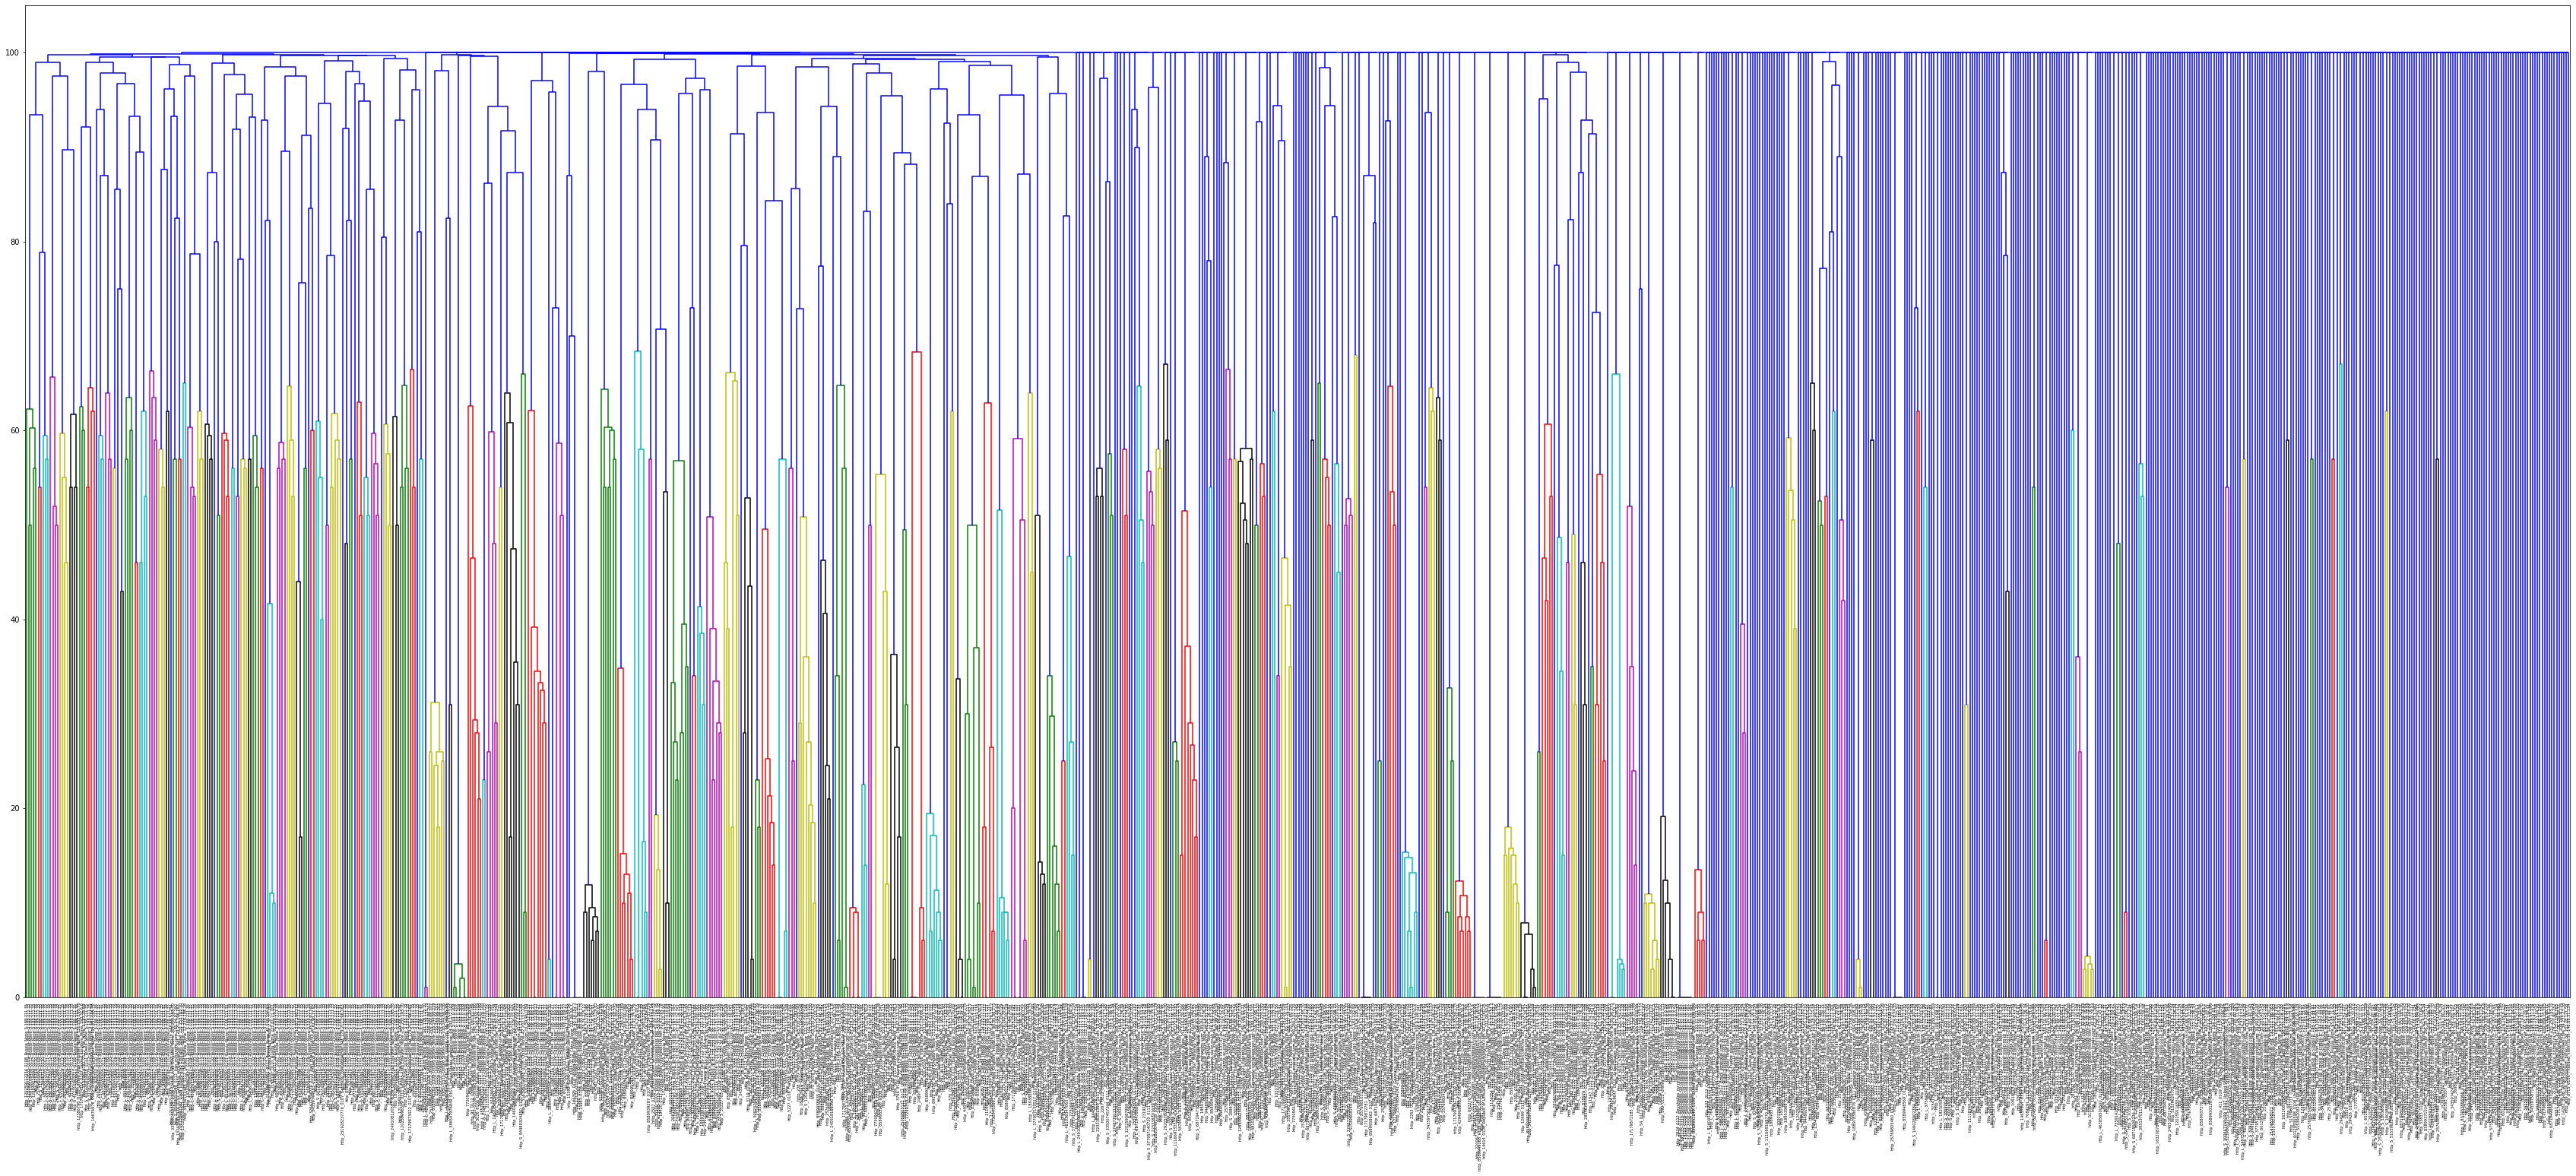

In [47]:
three_upgma_df = pair_wise_score(three_dict) #改!!
dn,Z = draw_upgma(three_upgma_df,
           picture_dir='/home/antslab/spark_data/pcap_inter/2020_01_06/中華電信/case_pictures/' #改!!
           ,name='0106-0112_upgma') #改!! 0106-0112_upgma

In [50]:
Z

array([[3.000e+00, 5.760e+02, 0.000e+00, 2.000e+00],
       [6.350e+02, 8.110e+02, 0.000e+00, 2.000e+00],
       [8.000e+00, 1.360e+02, 0.000e+00, 2.000e+00],
       ...,
       [1.732e+03, 2.103e+03, 1.000e+02, 8.870e+02],
       [1.122e+03, 2.104e+03, 1.000e+02, 8.890e+02],
       [1.727e+03, 2.105e+03, 1.000e+02, 1.054e+03]])

## 畫跨天protocol大小圖

In [368]:
proto_big_dict

{6: [231928233986,
  231928233987,
  34359738372,
  34359738373,
  60129542149,
  34359738375,
  42949672967,
  9,
  8589934602,
  11,
  8589934603,
  8589934604,
  17179869193,
  8589934607,
  17179869194,
  17179869197,
  17179869198,
  25769803793,
  25769803791,
  34359738389,
  34359738390,
  23,
  24,
  25769803800,
  8589934618,
  8589934619,
  8589934620,
  34359738391,
  8589934622,
  34359738393,
  32,
  33,
  17179869216,
  17179869218,
  17179869219,
  17179869220,
  25769803809,
  25769803810,
  34359738407,
  41,
  42,
  43,
  44,
  45,
  25769803819,
  8589934639,
  48,
  8589934640,
  25769803820,
  17179869229,
  25769803824,
  25769803827,
  34359738418,
  25769803828,
  34359738419,
  34359738416,
  34359738417,
  42949672970,
  42949673012,
  42949673013,
  8589934654,
  8589934655,
  8589934656,
  8589934657,
  8589934658,
  8589934659,
  17179869250,
  17179869251,
  17179869252,
  8589934663,
  8589934664,
  17179869253,
  74,
  75,
  17179869254,
  17179869255,


In [373]:
trend_dict_time_all = {}
trend_dict_country_all = {}
trend_dict_ip_all = {}
trend_dict_ssdeep_all = {}
def draw_trend_pic(date,proto,pickle_dir,trend_dict_time_all=trend_dict_time_all,trend_dict_country_all=trend_dict_country_all,trend_dict_ip_all=trend_dict_ip_all,trend_dict_ssdeep_all=trend_dict_ssdeep_all):
    '''
    GOAL: output dict to draw trend-circle picture
    
    Return: 4 dict for the same proto for the next day
    '''
    try:
        (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
                                proto_upgma_dict,stat_df) = pickle.load(open(pickle_dir+str(date)+'_'+str(proto)+'_all.pkl','rb'))
    except ValueError:
        (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
                                proto_upgma_dict) = pickle.load(open(pickle_dir+str(date)+'_'+str(proto)+'_all.pkl','rb'))
    except FileNotFoundError:
        print("!!File Not Found:",date,proto,"!!")
        return trend_dict_time_all,trend_dict_country_all,trend_dict_ip_all,trend_dict_ssdeep_all


    def ssdeep_compare(target_hash,candidate_df):
        '''
        Input1: string of hash
        Input2: dataframe of candidate
        '''
        def compare(candidate_hash):
            if type(candidate_hash) == str:
                return ssdeep.compare(target_hash,candidate_hash)
            else:
                score_li = []
                for c_h in candidate_hash:
                    score_li.append(ssdeep.compare(target_hash,c_h))
                return max(score_li)
        return candidate_df.hash.map(compare)

    trend_dict_time = {}
    trend_dict_country = {}
    trend_dict_ip = {}
    trend_dict_ssdeep = {}
    candidate_df = pd.DataFrame(trend_dict_ssdeep_all.items(),columns=['idx','hash']) #其他已經有的cluster
    for key,value in proto_big_dict.items():
        target = proto_df_payload[proto_df_payload.idx == key]
        target = target.reset_index(drop=True)
        t_len = len(target)
        q2 = int(t_len*0.5)
        t_q2_key = target.iloc[q2,-1] #要跟別人比較的cluster hash
        if trend_dict_ssdeep_all == {}: #第一次
            member_li = value[:]
            
            t_q2_member1 = proto_df_payload[proto_df_payload.idx == member_li[-2]] # member list最後一個
            t_q2_member1 = t_q2_member1.reset_index(drop=True)
            t_len = len(t_q2_member1)
            q2 = int(t_len*0.5)
            t_q2_member1 = t_q2_member1.iloc[q2,-1]
            
            t_q2_member2 = proto_df_payload[proto_df_payload.idx == max(member_li)] #member list最大的那個
            t_q2_member2 = t_q2_member2.reset_index(drop=True)
            t_len = len(t_q2_member2)
            q2 = int(t_len*0.5)
            t_q2_member2 = t_q2_member2.iloc[q2,-1]
            
            trend_dict_ssdeep[str(date)+"_"+str(key)] = [t_q2_key,t_q2_member1,t_q2_member2] #可以增加hash candidate?
            member_li.append(key)
            select_df = proto_df.loc[member_li]
            time_li = select_df.session_time.tolist()
            trend_dict_time[str(date)+"_"+str(key)] = time_li
            country_li = select_df.country.tolist()
            ip_li = select_df.ip_src.tolist()
            assert len(time_li) == len(country_li) == len(ip_li)
            trend_dict_country[str(date)+"_"+str(key)] = country_li
            trend_dict_ip[str(date)+"_"+str(key)] = ip_li
        else: #後面幾次
            candidate_df['score'] = ssdeep_compare(t_q2,candidate_df) 
            max_score = candidate_df.score.max()
            if max_score < 1: #都沒有相近的
                
                member_li = value[:]
                
                t_q2_member1 = proto_df_payload[proto_df_payload.idx == member_li[-2]] # member list最後一個
                t_q2_member1 = t_q2_member1.reset_index(drop=True)
                t_len = len(t_q2_member1)
                q2 = int(t_len*0.5)
                t_q2_member1 = t_q2_member1.iloc[q2,-1]

                t_q2_member2 = proto_df_payload[proto_df_payload.idx == max(member_li)] #member list最大的那個
                t_q2_member2 = t_q2_member2.reset_index(drop=True)
                t_len = len(t_q2_member2)
                q2 = int(t_len*0.5)
                t_q2_member2 = t_q2_member2.iloc[q2,-1]
                
                trend_dict_ssdeep[str(date)+"_"+str(key)] = [t_q2_key,t_q2_member1,t_q2_member2]
                member_li.append(key)
                select_df = proto_df.loc[member_li]
                time_li = select_df.session_time.tolist()
                trend_dict_time[str(date)+"_"+str(key)] = time_li
                country_li = select_df.country.tolist()
                ip_li = select_df.ip_src.tolist()
                assert len(time_li) == len(country_li) == len(ip_li)
                trend_dict_country[str(date)+"_"+str(key)] = country_li
                trend_dict_ip[str(date)+"_"+str(key)] = ip_li
            elif max_score>0: #有相近的合併到原本的dict
                try:
                    combine_id = candidate_df[candidate_df.score == max_score].idx.tolist()[0]
                except:
                    print( candidate_df,max_score,target)
                ori_ssdeep_list = trend_dict_ssdeep_all[combine_id][:]
                if type(ori_ssdeep_list) == str:
                    ori_ssdeep_list = [ori_ssdeep_list] #之前只有一個ssdeep hash
                ori_time_list = trend_dict_time_all[combine_id][:]
                ori_country_list = trend_dict_country_all[combine_id][:]
                ori_ip_list = trend_dict_ip_all[combine_id][:]
                member_li = value[:]
                
                t_q2_member1 = proto_df_payload[proto_df_payload.idx == member_li[-2]] # member list最後一個
                t_q2_member1 = t_q2_member1.reset_index(drop=True)
                t_len = len(t_q2_member1)
                q2 = int(t_len*0.5)
                t_q2_member1 = t_q2_member1.iloc[q2,-1]

                t_q2_member2 = proto_df_payload[proto_df_payload.idx == max(member_li)] #member list最大的那個
                t_q2_member2 = t_q2_member2.reset_index(drop=True)
                t_len = len(t_q2_member2)
                q2 = int(t_len*0.5)
                t_q2_member2 = t_q2_member2.iloc[q2,-1]                
                
                t_q2 = [t_q2_key,t_q2_member1,t_q2_member2]
                member_li.append(key)
                select_df = proto_df.loc[member_li]
                time_li = select_df.session_time.tolist()
                ori_time_list.extend(time_li)
                country_li = select_df.country.tolist()
                ip_li = select_df.ip_src.tolist()
                ori_country_list.extend(country_li)
                ori_ip_list.extend(ip_li)
                ori_ssdeep_list.extend(t_q2) #我合併進入別人的群，所以把我群的key hash也加入
                assert len(ori_time_list) == len(ori_country_list) == len(ori_ip_list)
                trend_dict_time_all[combine_id] = ori_time_list
                trend_dict_country_all[combine_id] = ori_country_list
                trend_dict_ip_all[combine_id] = ori_ip_list
                trend_dict_ssdeep_all[combine_id] = ori_ssdeep_list
            else:
                print(max_score)
#         break #debug
    trend_dict_time_all.update(trend_dict_time)
    trend_dict_country_all.update(trend_dict_country)
    trend_dict_ip_all.update(trend_dict_ip)
    trend_dict_ssdeep_all.update(trend_dict_ssdeep)
    return trend_dict_time_all,trend_dict_country_all,trend_dict_ip_all,trend_dict_ssdeep_all

In [372]:
def sort_li(time_li, country_li):
    '''
    GOAL: sort by time (align with time's order)
    Return: list
    '''
    sort_country_li = [x for _,x in sorted(zip(time_li,country_li))]
    return sort_country_li

In [260]:

# date_li = ["0110","0130","0102"]
date_li = ["0106","0107","0108","0109","0110","0111","0112"] #,"0102","0130"
# date_li = ["0102","0106","0107","0108","0109","0110","0111","0112","0130"] #,"0102","0130"
# date_li = ['0102','0130','0110']
proto_li = ['tds','http','smb','telnet','ftp','smtp','mysql','ssh','rpc','imap','pop','sip']
# proto_li = ['http']
for proto in tqdm(proto_li):
    trend_dict_time_all = {}
    trend_dict_country_all = {}
    trend_dict_ip_all = {}
    trend_dict_ssdeep_all = {}
    for date in date_li:
        pickle_dir = '/home/antslab/spark_data/pcap_inter/2020_01_'+str(date[-2:])+'/中華電信/case_pickles/'
        trend_dict_time_all,trend_dict_country_all,trend_dict_ip_all,trend_dict_ssdeep_all = draw_trend_pic(date,proto,
                                                                                          pickle_dir,trend_dict_time_all,trend_dict_country_all,trend_dict_ip_all,trend_dict_ssdeep_all)
    trend_dict_time_all = {k: v for k, v in sorted(trend_dict_time_all.items(), key=lambda item: len(item[1]),reverse=True)}
    time_df = pd.DataFrame(trend_dict_time_all.items(),columns=['idx','timestamp'])
    trend_dict_country_all = {k: v for k, v in sorted(trend_dict_country_all.items(), key=lambda item: len(item[1]),reverse=True)}
    country_df = pd.DataFrame(trend_dict_country_all.items(),columns=['idx','country'])
    trend_dict_ip_all = {k: v for k, v in sorted(trend_dict_ip_all.items(), key=lambda item: len(item[1]),reverse=True)}
    ip_df =  pd.DataFrame(trend_dict_ip_all.items(),columns=['idx','src_ip'])
    ssdeep_df = pd.DataFrame(trend_dict_ssdeep_all.items(),columns=['idx','ssdeep'])
    all_df = pd.merge(time_df,country_df,on='idx')
    all_df =  pd.merge(all_df,ip_df,on='idx')
    all_df = pd.merge(all_df,ssdeep_df,on='idx')
    all_df['country'] = all_df.apply(lambda x: sort_li(x.timestamp, x.country), axis=1)
    all_df['src_ip'] = all_df.apply(lambda x: sort_li(x.timestamp, x.src_ip), axis=1)
    all_df['timestamp'] = all_df.timestamp.map(sorted)
    file_name = "_".join(sorted(date_li))
    pickle.dump(obj=all_df,
                file=open('/home/antslab/spark_data/pcap_inter/2020_01_'+str(min(date_li)[-2:])+'/中華電信/case_pickles/'+proto+'_trend_df_'+file_name+'.pkl','wb'))

100%|██████████| 1/1 [03:34<00:00, 214.92s/it]


輸出cluster之key session的time list

In [399]:
proto_li = ['smb','telnet','ftp','smtp','mysql','ssh','rpc','imap','pop','sip']
# proto = 'tds' 'tds','http',

# date_li = ["0102","0106","0107","0108","0109","0110","0111","0112","0130"] #,"0102","0130"
date_li = ["0106","0107","0108","0109","0110","0111","0112"] #,"0102","0130"
# date_li = ['0102','0130','0110']
file_name = "_".join(sorted(date_li))

for proto in tqdm(proto_li):
    http_df = pickle.load(open('/home/antslab/spark_data/pcap_inter/2020_01_'+str(min(date_li)[-2:])+'/中華電信/case_pickles/'+proto+'_trend_df_'+file_name+'.pkl','rb'))

    #輸出cluster之key session的time list
    wireshark_li = http_df.idx.tolist() #.head(15)前15大cluster #改!proto
    wireshark_rank = []
    for i,v in enumerate(wireshark_li):
        wireshark_rank.append(i+1)
    wireshark_rank = [x for _,x in sorted(zip(wireshark_li,wireshark_rank))]
    wireshark_li = sorted(wireshark_li)

    save_path_li = []
    now_date = '00' #現在正在處理的日期
    for i,wireshark in zip(wireshark_rank,wireshark_li):
        date = wireshark.split('_')[0] #該cluster key的同月份日期
        if date!= now_date: #新日期才要重讀
            now_date = date

            pickle_dir = '/home/antslab/spark_data/pcap_inter/2020_01_'+str(date[-2:])+'/中華電信/case_pickles/'
            try:
                (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
                                        proto_upgma_dict,stat_df) = pickle.load(open(pickle_dir+str(date)+'_'+str(proto)+'_all.pkl','rb'))
            except ValueError:
                (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
                                        proto_upgma_dict) = pickle.load(open(pickle_dir+str(date)+'_'+str(proto)+'_all.pkl','rb'))
            except FileNotFoundError:
                continue
        idx = wireshark.split('_')[-1] #該cluster在該日期該proto的df中的index
        #     else:
        try:
            time_list = proto_df.loc[int(idx),'session_time_list'].tolist()
        except AttributeError:
            time_list = proto_df.loc[int(idx),'session_time_list']
        timelist_path = pickle_dir+'timelist_'+proto+'_large#'+str(i)+'_clusterID#'+str(idx)+'.pkl'
        pickle.dump(file=open(timelist_path,'wb'),obj=time_list)
#         print(wireshark,'save in:',timelist_path) #truly save path
        save_path_li.append(timelist_path)

    first_date = wireshark_li[0].split('_')[0][-2:]
    save_path = '/home/antslab/spark_data/pcap_inter/2020_01_'+first_date+'/中華電信/case_pickles/'+proto+'_clusterKey_timelist_paths_'+file_name+'.pkl'
    pickle.dump(file=open(save_path,'wb'),obj=save_path_li)  
    print(proto,':',save_path) #for 証鴻 pickle save path


# http_df

 10%|█         | 1/10 [00:09<01:26,  9.61s/it]

smb : /home/antslab/spark_data/pcap_inter/2020_01_06/中華電信/case_pickles/smb_clusterKey_timelist_paths_0106_0107_0108_0109_0110_0111_0112.pkl


 20%|██        | 2/10 [00:11<00:57,  7.23s/it]

telnet : /home/antslab/spark_data/pcap_inter/2020_01_06/中華電信/case_pickles/telnet_clusterKey_timelist_paths_0106_0107_0108_0109_0110_0111_0112.pkl


 30%|███       | 3/10 [00:31<01:17, 11.12s/it]

ftp : /home/antslab/spark_data/pcap_inter/2020_01_06/中華電信/case_pickles/ftp_clusterKey_timelist_paths_0106_0107_0108_0109_0110_0111_0112.pkl


 50%|█████     | 5/10 [00:33<00:29,  5.83s/it]

smtp : /home/antslab/spark_data/pcap_inter/2020_01_06/中華電信/case_pickles/smtp_clusterKey_timelist_paths_0106_0107_0108_0109_0110_0111_0112.pkl
mysql : /home/antslab/spark_data/pcap_inter/2020_01_06/中華電信/case_pickles/mysql_clusterKey_timelist_paths_0106_0107_0108_0109_0110_0111_0112.pkl


 60%|██████    | 6/10 [01:54<01:54, 28.59s/it]

ssh : /home/antslab/spark_data/pcap_inter/2020_01_06/中華電信/case_pickles/ssh_clusterKey_timelist_paths_0106_0107_0108_0109_0110_0111_0112.pkl


 80%|████████  | 8/10 [01:56<00:28, 14.40s/it]

rpc : /home/antslab/spark_data/pcap_inter/2020_01_06/中華電信/case_pickles/rpc_clusterKey_timelist_paths_0106_0107_0108_0109_0110_0111_0112.pkl
imap : /home/antslab/spark_data/pcap_inter/2020_01_06/中華電信/case_pickles/imap_clusterKey_timelist_paths_0106_0107_0108_0109_0110_0111_0112.pkl


100%|██████████| 10/10 [01:56<00:00, 11.70s/it]

pop : /home/antslab/spark_data/pcap_inter/2020_01_06/中華電信/case_pickles/pop_clusterKey_timelist_paths_0106_0107_0108_0109_0110_0111_0112.pkl
sip : /home/antslab/spark_data/pcap_inter/2020_01_06/中華電信/case_pickles/sip_clusterKey_timelist_paths_0106_0107_0108_0109_0110_0111_0112.pkl


In [ ]:
def timestamp_cut_country(time_li,country_li):
    thr_lower = 1577887200
    thr_upper = 1577984400 #2020-01-03 01
    c_li = []
#     i_li = []
    for t,c,i in zip(time_li,country_li):
        if thr_lower<t<thr_upper:
            c_li.append(c)
#             i_li.append(i)
    return c_li

# def timestamp_cut_ip(time_li,country_li,ip_li):
#     thr_lower = 1577887200
#     thr_upper = 1577984400 #2020-01-03 01
#     c_li = []
#     i_li = []
#     for t,c,i in zip(time_li,country_li,ip_li):
#         if 1577887200<t<thr_upper:
#             c_li.append(c)
#             i_li.append(i)
#     return i_li

In [88]:
# time.mktime(time.strptime('2020-01-03 01','%Y-%m-%d %H'))

1577984400.0

In [395]:
#輸出cluster之key session的time list
wireshark_li = http_df.idx.tolist() #.head(15)前15大cluster #改!proto
wireshark_rank = []
for i,v in enumerate(wireshark_li):
    wireshark_rank.append(i+1)
wireshark_rank = [x for _,x in sorted(zip(wireshark_li,wireshark_rank))]
wireshark_li = sorted(wireshark_li)

save_path_li = []
now_date = '00' #現在正在處理的日期
for i,wireshark in tqdm(zip(wireshark_rank,wireshark_li)):
    date = wireshark.split('_')[0] #該cluster key的同月份日期
    if date!= now_date: #新日期才要重讀
        now_date = date
        
        pickle_dir = '/home/antslab/spark_data/pcap_inter/2020_01_'+str(date[-2:])+'/中華電信/case_pickles/'
        try:
            (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
                                    proto_upgma_dict,stat_df) = pickle.load(open(pickle_dir+str(date)+'_'+str(proto)+'_all.pkl','rb'))
        except ValueError:
            (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
                                    proto_upgma_dict) = pickle.load(open(pickle_dir+str(date)+'_'+str(proto)+'_all.pkl','rb'))
        except FileNotFoundError:
            continue
    idx = wireshark.split('_')[-1] #該cluster在該日期該proto的df中的index
    #     else:
    try:
        time_list = proto_df.loc[int(idx),'session_time_list'].tolist()
    except AttributeError:
        time_list = proto_df.loc[int(idx),'session_time_list']
    timelist_path = pickle_dir+'timelist_'+proto+'_large#'+str(i)+'_clusterID#'+str(idx)+'.pkl'
    pickle.dump(file=open(timelist_path,'wb'),obj=time_list)
    print(wireshark,'save in:',timelist_path)
    save_path_li.append(timelist_path)

first_date = wireshark_li[0].split('_')[0][-2:]
save_path = '/home/antslab/spark_data/pcap_inter/2020_01_'+first_date+'/中華電信/case_pickles/'+proto+'_clusterKey_timelist_paths_'+file_name+'.pkl'
pickle.dump(file=open(save_path,'wb'),obj=save_path_li)  
print('all paths in:',save_path)

1it [08:48, 528.90s/it]

0106_103079224354 save in: /home/antslab/spark_data/pcap_inter/2020_01_06/中華電信/case_pickles/timelist_tds_large#12_clusterID#103079224354.pkl
0106_1082 save in: /home/antslab/spark_data/pcap_inter/2020_01_06/中華電信/case_pickles/timelist_tds_large#16_clusterID#1082.pkl
0106_13 save in: /home/antslab/spark_data/pcap_inter/2020_01_06/中華電信/case_pickles/timelist_tds_large#2_clusterID#13.pkl
0106_13586 save in: /home/antslab/spark_data/pcap_inter/2020_01_06/中華電信/case_pickles/timelist_tds_large#21_clusterID#13586.pkl
0106_197568509571 save in: /home/antslab/spark_data/pcap_inter/2020_01_06/中華電信/case_pickles/timelist_tds_large#34_clusterID#197568509571.pkl
0106_2138 save in: /home/antslab/spark_data/pcap_inter/2020_01_06/中華電信/case_pickles/timelist_tds_large#26_clusterID#2138.pkl
0106_2200 save in: /home/antslab/spark_data/pcap_inter/2020_01_06/中華電信/case_pickles/timelist_tds_large#24_clusterID#2200.pkl
0106_2264 save in: /home/antslab/spark_data/pcap_inter/2020_01_06/中華電信/case_pickles/timelist_tds

31it [10:06, 371.00s/it]

0107_8589939281 save in: /home/antslab/spark_data/pcap_inter/2020_01_07/中華電信/case_pickles/timelist_tds_large#31_clusterID#8589939281.pkl


32it [10:19, 263.66s/it]

0108_14180 save in: /home/antslab/spark_data/pcap_inter/2020_01_08/中華電信/case_pickles/timelist_tds_large#23_clusterID#14180.pkl
0108_4060 save in: /home/antslab/spark_data/pcap_inter/2020_01_08/中華電信/case_pickles/timelist_tds_large#9_clusterID#4060.pkl


34it [10:22, 18.32s/it] 

0112_4400 save in: /home/antslab/spark_data/pcap_inter/2020_01_12/中華電信/case_pickles/timelist_tds_large#29_clusterID#4400.pkl
all paths in: /home/antslab/spark_data/pcap_inter/2020_01_06/中華電信/case_pickles/tds_clusterKey_timelist_paths_0106_0107_0108_0109_0110_0111_0112.pkl


輸出clique圖的case study (跨天、跨protocol)

In [252]:
#輸出clique圖的case study (跨天、跨protocol)

in_file = '/home/antslab/spark_data/pcap_inter/2020_01_06/中華電信/case_pickles/clique_34459.pkl'
out_filename = in_file.split('/')[-1].split('.')[0]
list_tuples = pickle.load(open(in_file,'rb'))
case_wireshark_df = pd.DataFrame(list_tuples,columns =['Date', 'Protocol', 'SessionTime'])
print(out_filename)
case_wireshark_df

clique_34459


Date Protocol   SessionTime
0     6      ftp  1.578298e+09
1     6      ftp  1.578302e+09
2     8      pop  1.578438e+09
3     8      pop  1.578438e+09
4     8      pop  1.578438e+09

In [253]:
def convert_date(s):
    '''
    將日期加上月份
    '''
    mo = '01'
    date = str(s)
    if len(date)==1:
        return mo+'0'+date
    elif len(date)==2:
        return mo+date
case_wireshark_df['Date'] = case_wireshark_df.Date.map(convert_date)
case_wireshark_df = case_wireshark_df.sort_values(['Date','Protocol'],ascending=[True,True])
case_wireshark_df = case_wireshark_df.reset_index(drop=True)
case_wireshark_df

Date Protocol   SessionTime
0  0106      ftp  1.578298e+09
1  0106      ftp  1.578302e+09
2  0108      pop  1.578438e+09
3  0108      pop  1.578438e+09
4  0108      pop  1.578438e+09

In [254]:
date_li = list(set(case_wireshark_df.Date.tolist()))
date_li = sorted(date_li)
for date in date_li:
    date_df = case_wireshark_df[case_wireshark_df.Date == date]
    all_time_li = [] #所有protocl一起存放成一個當案
    proto_li = list(set(date_df.Protocol.tolist()))
    proto_li = sorted(proto_li)
    for proto in proto_li:
        pickle_dir = '/home/antslab/spark_data/pcap_inter/2020_'+str(date[:2])+'_'+str(date[-2:])+'/中華電信/case_pickles/'
        try:
            (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
                                    proto_upgma_dict,stat_df) = pickle.load(open(pickle_dir+str(date)+'_'+str(proto)+'_all.pkl','rb'))
        except ValueError:
            (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
                                    proto_upgma_dict) = pickle.load(open(pickle_dir+str(date)+'_'+str(proto)+'_all.pkl','rb'))
        except FileNotFoundError:
            print('!!NO FILE:',date,proto,'!!')
            continue
        date_proto_df = date_df[date_df.Protocol == proto]
        session_time_li = date_proto_df.SessionTime.tolist()
        need_df = proto_df[proto_df.session_time.isin(session_time_li)]
        try:
            time_lists = need_df.session_time_list.tolist()
        except AttributeError:
            time_lists = need_df.session_time_list.values
        time_lists = [list(x) for x in time_lists]
        all_time_li.extend(time_lists)
    out_path = pickle_dir+out_filename+'_session_time_list.pkl'
    pickle.dump(file=open(out_path,'wb'),obj=all_time_li)
    print(out_filename,date,':',out_path)

         

clique_34459 0106 : /home/antslab/spark_data/pcap_inter/2020_01_06/中華電信/case_pickles/clique_34459_session_time_list.pkl
clique_34459 0108 : /home/antslab/spark_data/pcap_inter/2020_01_08/中華電信/case_pickles/clique_34459_session_time_list.pkl


#### 新關聯方法
* topology
    * 我們會先找所給定期間的指定所有protocols之所有sessions與對應IPs
    * 接下來會利用此段期間的各IP，去尋找這個IP在這段期間做的手法(攻擊樣態群集)
    * 找出不同IP所橫跨對應的攻擊樣態群，計算jaccard相似度
    * 將所採用相似手法(score>thr)的IP群聚

In [353]:
proto_li = ['tds','http','smb','telnet','ftp','smtp','mysql','ssh','rpc','imap','pop','sip']
# date_li = ["0102","0106","0107","0108","0109","0110","0111","0112","0130"] 
date_li = ["0106","0107","0108","0109","0110","0111","0112"] 
# date_li = ['0102','0130','0110']
file_name = "_".join(sorted(date_li))
for i,proto in enumerate(proto_li):
    if i==0:
        all_df = pickle.load(file=open('/home/antslab/spark_data/pcap_inter/2020_01_'+str(min(date_li)[-2:])+'/中華電信/case_pickles/'+proto+'_trend_df_'+file_name+'.pkl','rb'))
        all_df['idx'] = all_df['idx']+'_'+proto
    else:
        temp = pickle.load(file=open('/home/antslab/spark_data/pcap_inter/2020_01_'+str(min(date_li)[-2:])+'/中華電信/case_pickles/'+proto+'_trend_df_'+file_name+'.pkl','rb'))
        temp['idx'] = temp['idx']+'_'+proto
        all_df = all_df.append(temp)
all_df = all_df.reset_index(drop=True)
all_df

idx                                          timestamp  \
0              0106_38_tds  [1578239428.513828, 1578239428.527958, 1578239...   
1              0106_13_tds  [1578239428.699379, 1578239429.100849, 1578239...   
2             0106_289_tds  [1578239429.447062, 1578239429.474265, 1578239...   
3    0106_257698049845_tds  [1578247196.969601, 1578256397.518171, 1578334...   
4            0106_2264_tds  [1578239446.030398, 1578239450.34886, 15782394...   
..                     ...                                                ...   
751  0112_309237649836_pop             [1578763732.344271, 1578763738.515355]   
752   0106_51539621821_sip  [1578320874.953381, 1578320874.955226, 1578320...   
753           0106_465_sip  [1578239559.052485, 1578239573.363544, 1578239...   
754         0106_15413_sip  [1578258159.385014, 1578258159.400618, 1578258...   
755       0110_3451217_sip  [1578641805.427443, 1578641805.450811, 1578641...   

                                               country  \
0    [Philippines, Russia, Japan, Japan, Russia, Ja...   
1    [Japan, Russia, Russia, Russia, Russia, Philip...   
2    [Turkey, Brazil, Turkey, Turkey, Philippines, ...   
3    [Taiwan, Taiwan, China, China, China, China, C...   
4    [Taiwan, Brazil, Taiwan, Taiwan, Taiwan, Russi...   
..                                                 ...   
751                                     [China, China]   
752  [Estonia, Estonia, Estonia, Estonia, Estonia, ...   
753  [United States, United States, United States, ...   
754  [Estonia, Estonia, Estonia, Estonia, Estonia, ...   
755  [China, China, China, China, China, China, Chi...   

                                                src_ip  \
0    [210.213.73.170, 93.81.185.139, 1.33.83.132, 1...   
1    [1.33.83.132, 93.81.185.139, 93.81.185.139, 93...   
2    [217.131.4.46, 177.38.54.186, 217.131.4.46, 21...   
3    [210.242.49.2, 210.242.49.2, 210.36.22.214, 21...   
4    [210.59.176.37, 177.38.54.186, 210.242.49.2, 2...   
..                                                 ...   
751                         [211.95.50.8, 211.95.50.7]   
752  [37.49.230.91, 37.49.230.91, 37.49.230.91, 37....   
753  [104.140.188.14, 104.140.188.14, 170.130.187.1...   
754  [77.247.110.179, 77.247.110.179, 77.247.110.17...   
755  [202.107.226.3, 202.107.226.3, 202.107.226.3, ...   

                                                ssdeep  
0    [12:MdjfmxTvuw36ItVE6YlBht4xaUpA+Oi5O/nJ:M49uw...  
1    [3:OfVGX4V9VfV1V1V1V1UQ91BVWfg0VZ39LfVbHfVYN1V...  
2    [12:M5epX+xTvuw3zLw9VCUn/6WfEFO+vXVyAA+Oi5OOVl...  
3    [12:MfTxTvuw3kG6OGB3eVxVZ+ytZpP9YVoRA+Oi5spJ:M...  
4    [12:MtSyxTvuw3d4AJG6Ai5KOm1NUGheU2A+Oi5OBVlJ:M...  
..                                                 ...  
751                   3:s671FIL7Q/V1V//vV1VYB:s6fIL7QI  
752  [24:pSMfChnz09MfXMffnQmDED8Xzg1ge0v8Xz/BZsKiXY...  
753  [24:qgOf3vI7mDL5gizTKiqf3vX4v/DRt0UUgbYMfy1wUX...  
754  24:sPLTON5F7mDEUd1TjgMRPwKimPLTON5NC9LTON51efX...  
755  24:qgcF8EL7mDE70a2ftSF4KinF8Eyd+UZF8EFymZ0JECI...  

[756 rows x 5 columns]

In [354]:
#find all ips
all_ips = all_df.src_ip.tolist()
all_ips = sum(all_ips,[])
all_ips = list(set(all_ips))
all_ips = sorted(all_ips)
# col_li = ['Country']
# col_li.extend(all_df.idx.tolist())
col_li = all_df.idx.tolist()
jc_matrix = pd.DataFrame(0, index=all_ips, columns=col_li)

In [355]:
for col in tqdm(jc_matrix.columns.tolist()):
    select_df = all_df[all_df.idx == col]
    ip_li = list(select_df.src_ip.values)
    ip_li = ip_li[0]
    jc_matrix.loc[ip_li,col] = 1
jc_matrix['np_array'] = list(jc_matrix.values)#.ravel()
jc_matrix

100%|██████████| 756/756 [00:08<00:00, 93.50it/s]


0106_38_tds  0106_13_tds  0106_289_tds  0106_257698049845_tds  \
1.0.128.212              0            0             0                      0   
1.0.134.96               0            0             0                      0   
1.0.135.97               0            0             0                      0   
1.0.139.246              0            0             0                      0   
1.0.153.160              0            0             0                      0   
...                    ...          ...           ...                    ...   
99.81.0.86               0            0             0                      0   
99.89.116.178            0            0             0                      0   
99.89.92.55              0            0             0                      0   
99.93.68.47              0            0             0                      0   
99.99.139.67             0            0             0                      0   

               0106_2264_tds  0106_5969_tds  0106_755_tds  0106_312_tds  \
1.0.128.212                0              0             0             0   
1.0.134.96                 0              0             0             0   
1.0.135.97                 0              0             0             0   
1.0.139.246                0              0             0             0   
1.0.153.160                0              0             0             0   
...                      ...            ...           ...           ...   
99.81.0.86                 0              0             0             0   
99.89.116.178              0              0             0             0   
99.89.92.55                0              0             0             0   
99.93.68.47                0              0             0             0   
99.99.139.67               0              0             0             0   

               0108_4060_tds  0106_8874_tds  0106_729_tds  \
1.0.128.212                0              0             0   
1.0.134.96                 0              0             0   
1.0.135.97                 0              0             0   
1.0.139.246                0              0             0   
1.0.153.160                0              0             0   
...                      ...            ...           ...   
99.81.0.86                 0              0             0   
99.89.116.178              0              0             0   
99.89.92.55                0              0             0   
99.93.68.47                0              0             0   
99.99.139.67               0              0             0   

               0106_103079224354_tds  0106_575_tds  0106_51539626635_tds  \
1.0.128.212                        0             0                     0   
1.0.134.96                         0             0                     0   
1.0.135.97                         0             0                     0   
1.0.139.246                        0             0                     0   
1.0.153.160                        0             0                     0   
...                              ...           ...                   ...   
99.81.0.86                         0             0                     0   
99.89.116.178                      0             0                     0   
99.89.92.55                        0             0                     0   
99.93.68.47                        0             0                     0   
99.99.139.67                       0             0                     0   

               0106_2872_tds  0106_1082_tds  0106_2575_tds  0106_5977_tds  \
1.0.128.212                0              0              0              0   
1.0.134.96                 0              0              0              0   
1.0.135.97                 0              0              0              0   
1.0.139.246                0              0              0              0   
1.0.153.160                0              0              0              0   
...                      ...            ...  

In [374]:
def calc_jac(c_value,t_value):
    return jaccard_score(c_value, t_value)

def calc_cos(c_value,t_value):
    return cosine_similarity(c_value, t_value)

In [361]:
thr=0.8
jc_dict = {}
ip_li = jc_matrix.index.tolist()
used_ip = []
for ip in tqdm(ip_li):
    if ip in used_ip:
        continue
    t_value = jc_matrix.loc[ip,'np_array']#.values
    jc_calc = jc_matrix[~jc_matrix.index.isin(used_ip)] #合併過得拿掉
    jc_calc = jc_calc[jc_calc.index != ip] #自己的不比
    jc_calc['jc_score'] = jc_calc.np_array.apply(calc_jac,args=(t_value,)) #得到t跟每個c的分數
#     jc_calc['co_score'] = jc_calc.np_array.apply(calc_cos,args=(t_value,)) #得到t跟每個c的分數
    combine_df = jc_calc[jc_calc['jc_score']>thr] #所設定的相似度分數
    c_ips_li = combine_df.index.tolist() #跟這個IP具高度相似度的IPs
    if len(c_ips_li)>0:
        jc_dict[ip] = c_ips_li
        used_ip.extend(c_ips_li)
        used_ip.append(ip)
#     for ip_c in ip_li[i+1:]:
#         c_value = jc_matrix.loc[ip_c].values
#         score = jaccard_score(t_value, c_value)
#         if score > 0.8: #合併分數
#             try:
#                 ori_li = jc_dict[ip][:]
#                 ori_li.append(ip_c)
#                 jc_dict[ip] = ori_li
#             except KeyError:
#                 jc_dict[ip] = [ip_c]
loner_ip = list(set(ip_li) - set(used_ip))
pickle_path = '/home/antslab/spark_data/pcap_inter/2020_01_'+str(min(date_li)[-2:])+'/中華電信/case_pickles/'+'CorrelateIP_APTIP_thr'+str(thr)+'_'+file_name+'.pkl'
pickle.dump(obj=(jc_dict,loner_ip),file=open(pickle_path,'wb'))
print('集團數量(IP>1,score>'+str(thr)+'):',len(jc_dict),"LonerIP數量:",len(loner_ip))

#thr=0.9: 集團數量(IP>1,score>thr): 996 LonerIP數量: 1897
#thr=0.8: 集團數量(IP>1,score>thr): 1005 LonerIP數量: 1566

 77%|███████▋  | 98604/128847 [1:33:45<13:30, 37.33it/s]   IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [569]:
def find(myList,target ):
    return [i for i,j in enumerate(myList) if j == target]
def find_time(indexes,li):
    '''
    一個IP回傳一個time list
    '''
    return list(map(li.__getitem__, indexes))
def find_country(need_index,candidate_li):
    '''
    一個IP只回傳一個country
    '''
    return candidate_li[need_index[0]]
def repeat_idx(ori_li,index):
    return [index]*len(ori_li)

In [565]:
# import more_itertools as mit
# from timeit import timeit

# data = list(range(1000))
# data.extend([1,2,1,1])
# def find_iter(data,target):
#     return list(mit.locate(data, lambda x: x == target))
# value=1
# ttt=2000
# t1 = timeit(lambda: find_iter(data,value), number=ttt)
# t2 = timeit(lambda: find(data, value), number=ttt)
# t1,t2

(0.1176293371245265, 0.06326391384936869)

In [581]:
%%time
# 綜合所需的表，只要跑一次 [增加country資訊] [增加loner可使用]
jc_matrix2 = jc_matrix.drop(['np_array'],axis=1)
def find2(t_ip): #同個target ip
    temp = jc_matrix2[jc_matrix2.index == t_ip]
    t_idx = temp.columns[temp.eq(1).any()]
    temp2 = all_df[all_df.idx.isin(t_idx)]
    temp2['gen'] = temp2.src_ip.apply(find,args=(t_ip,))
    temp2['time_li'] = temp2.apply(lambda x: find_time(x.gen, x.timestamp), axis=1)
    temp2['idx_li'] = temp2.apply(lambda x: repeat_idx(x.time_li, x.idx), axis=1)
    temp2['country'] =  temp2.apply(lambda x: find_country(x.gen, x.country), axis=1)
#     return temp2['time_li'].tolist() #list of lists
    return functools.reduce(operator.iconcat, temp2['time_li'].tolist(), []),functools.reduce(operator.iconcat, temp2['idx_li'].tolist(), []), temp2['country'].iloc[0] 

ip_li = jc_matrix.index.tolist()
ip_df = pd.DataFrame(ip_li,columns=['src_ip'])
ip_df['session_timelist'],ip_df['session_idlist'],ip_df['session_county'] = zip(*ip_df['src_ip'].apply(find2))
ip_df

/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

CPU times: user 2h 29min 40s, sys: 1min 2s, total: 2h 30min 43s
Wall time: 2h 30min 42s


src_ip                                   session_timelist  \
0         1.0.128.212  [1578384430.832694, 1578384445.297486, 1578384...   
1          1.0.134.96                                [1578514442.673096]   
2          1.0.135.97                                [1578476713.047045]   
3         1.0.139.246  [1578536402.206263, 1578536540.582541, 1578536...   
4         1.0.153.160             [1578310949.890009, 1578351209.654226]   
...               ...                                                ...   
128842     99.81.0.86  [1578355289.559914, 1578355443.161001, 1578356...   
128843  99.89.116.178             [1578790711.506938, 1578800648.286576]   
128844    99.89.92.55  [1578246731.552352, 1578268505.862363, 1578278...   
128845    99.93.68.47                                [1578582701.082341]   
128846   99.99.139.67  [1578244996.87408, 1578264306.809042, 15784464...   

                                           session_idlist session_county  
0       [0106_0_smb, 0106_0_smb, 0106_0_smb, 0106_0_sm...       Thailand  
1                                         [0106_252_http]       Thailand  
2                                            [0106_0_smb]       Thailand  
3       [0106_0_smb, 0106_0_smb, 0106_0_smb, 0106_0_sm...       Thailand  
4                           [0106_3_http, 0106_4752_http]       Thailand  
...                                                   ...            ...  
128842  [0106_7_ssh, 0106_7_ssh, 0106_7_ssh, 0106_7_ss...        Ireland  
128843                         [0106_3_http, 0106_3_http]  United States  
128844  [0106_7_ssh, 0106_7_ssh, 0106_7_ssh, 0106_7_ss...  United States  
128845                                   [0106_4752_http]  United States  
128846  [0106_3_http, 0106_3_http, 0106_3_http, 0106_3...  United States  

[128847 rows x 4 columns]

In [582]:
#TRAIN SAVE:
pickle_dir = '/home/antslab/spark_data/pcap_inter/2020_01_'+str(min(date_li)[-2:])+'/中華電信/case_pickles/'  
pickle.dump(obj=ip_df,file=open(pickle_dir+'CorrelateIP_ALL_ip_df.pkl','wb'))

INFERENCE

In [588]:
date_li = ["0106","0107","0108","0109","0110","0111","0112"] 
file_name = "_".join(sorted(date_li))
thr = 0.9

pickle_dir = '/home/antslab/spark_data/pcap_inter/2020_01_'+str(min(date_li)[-2:])+'/中華電信/case_pickles/'  
ip_df = pickle.load(open(pickle_dir+'CorrelateIP_ALL_ip_df.pkl','rb'))

pickle_path = '/home/antslab/spark_data/pcap_inter/2020_01_'+str(min(date_li)[-2:])+'/中華電信/case_pickles/'+'CorrelateIP_APTIP_thr'+str(thr)+'_'+file_name+'.pkl'
jc_dict,loner_ip = pickle.load(open(pickle_path,'rb'))

similarity_id_list = []
timelist_dict_list = []
clusterlist_dict_list = []
# country_dict = []
country_list = []

for cluster_id, ip_li in tqdm(jc_dict.items()):
    all_ips = ip_li[:]
    all_ips.append(cluster_id)
    temp = ip_df[ip_df.src_ip.isin(all_ips)]
    temp_time = temp.set_index('src_ip')['session_timelist'].to_dict()
    temp_id = temp.set_index('src_ip')['session_idlist'].to_dict()
#     temp_country = temp.set_index('src_ip')['country'].to_dict()
    temp_country = temp['session_county'].tolist()
    similarity_id_list.append(cluster_id) #僅識別用
    timelist_dict_list.append(temp_time)
    clusterlist_dict_list.append(temp_id)
    country_list.append(temp_country)
pattern_select_df = pd.DataFrame([similarity_id_list,timelist_dict_list,clusterlist_dict_list,country_list],
             index=['pattern_key','sessions_time_dict','cluster_id_dict','country_list']).T
save_path = pickle_dir+'CorrelateIP_DRAW_'+str(thr)+'.pkl'
pickle.dump(obj=pattern_select_df,file=open(save_path,'wb'))
print("集團數量(IP>1,score>thr):",len(jc_dict),"LonerIP數量:",len(loner_ip))
print('視覺化路徑:',save_path)
pattern_select_df

100%|██████████| 996/996 [00:05<00:00, 182.26it/s]


集團數量(IP>1,score>thr): 996 LonerIP數量: 1897
視覺化路徑: /home/antslab/spark_data/pcap_inter/2020_01_06/中華電信/case_pickles/CorrelateIP_DRAW_0.9.pkl


pattern_key                                 sessions_time_dict  \
0      1.0.128.212  {'1.0.128.212': [1578384430.832694, 1578384445...   
1       1.0.134.96  {'1.0.134.96': [1578514442.673096], '1.1.141.2...   
2      1.0.153.160  {'1.0.153.160': [1578310949.890009, 1578351209...   
3       1.0.164.67  {'1.0.164.67': [1578819489.156265], '1.0.211.2...   
4      1.0.166.181  {'1.0.166.181': [1578268516.650914], '1.1.136....   
..             ...                                                ...   
991  83.142.52.241  {'83.142.52.241': [1578500841.075102], '85.202...   
992    85.93.20.10  {'85.93.20.10': [1578423196.968576, 1578423260...   
993   86.47.80.148  {'86.47.80.148': [1578542811.159667], '89.234....   
994  92.118.161.29  {'92.118.161.29': [1578331808.140179, 15783877...   
995  92.242.40.115  {'92.242.40.115': [1578272693.590196, 15782790...   

                                       cluster_id_dict  \
0    {'1.0.128.212': ['0106_0_smb', '0106_0_smb', '...   
1    {'1.0.134.96': ['0106_252_http'], '1.1.141.249...   
2    {'1.0.153.160': ['0106_3_http', '0106_4752_htt...   
3    {'1.0.164.67': ['0106_3766_http'], '1.0.211.24...   
4    {'1.0.166.181': ['0106_3_http'], '1.1.136.114'...   
..                                                 ...   
991  {'83.142.52.241': ['0109_103079243509_http'], ...   
992  {'85.93.20.10': ['0108_442_mysql', '0108_442_m...   
993  {'86.47.80.148': ['0109_34359752625_http'], '8...   
994  {'92.118.161.29': ['0107_4581_http', '0107_458...   
995  {'92.242.40.115': ['0106_13_tds', '0106_13_tds...   

                                          country_list  
0    [Thailand, Thailand, Thailand, Thailand, Thail...  
1    [Thailand, Thailand, Thailand, Thailand, Thail...  
2    [Thailand, Thailand, South Korea, South Korea,...  
3    [Thailand, Thailand, Thailand, Thailand, Austr...  
4    [Thailand, Thailand, Thailand, Thailand, Thail...  
..                                                 ...  
991                                  [Russia, Germany]  
992       [Poland, Germany, Germany, Germany, Germany]  
993                                 [Ireland, Ireland]  
994  [Republic of Lithuania, Republic of Lithuania,...  
995                                   [Russia, Russia]  

[996 rows x 4 columns]

In [529]:
# #可以直接畫好trend圖
# similarity_id_list = []
# timelist_dict_list = []
# clusterlist_dict_list = []
# jc_matrix2 = jc_matrix.drop(['np_array'],axis=1)
# for cluster_id, ip_li in tqdm(jc_dict.items()):
#     similarity_id_list.append(cluster_id) #僅識別用
#     all_ips = ip_li[:]
#     all_ips.append(cluster_id)
#     timelist_dict = {}
#     clusterlist_dict = {}
#     for t_ip in all_ips: #這個IP有橫跨的IDX，都屬於這個ip的
#         temp = jc_matrix2[jc_matrix2.index == t_ip]
#         t_idx = temp.columns[temp.eq(1).any()]
#         temp2 = all_df[all_df.idx.isin(t_idx)]
#         temp2['gen'] = temp2.src_ip.apply(find,args=(t_ip,))
#         temp2['time_li'] = temp2.apply(lambda x: find_time(x.gen, x.timestamp), axis=1)
#         temp2['idx_li'] = temp2.apply(lambda x: repeat_idx(x.time_li, x.idx), axis=1)        
#         timestamps_lists = temp2['time_li'].tolist() #list of lists
#         cluster_name_list = temp2['idx_li'].tolist()#list of lists
#         timelist_dict[t_ip] = functools.reduce(operator.iconcat, timestamps_lists, [])
#         clusterlist_dict[t_ip] = functools.reduce(operator.iconcat, cluster_name_list, [])
        
#     timelist_dict_list.append(timelist_dict)
#     clusterlist_dict_list.append(clusterlist_dict)
#     assert len(similarity_id_list) == len(timelist_dict_list) == len(clusterlist_dict_list)
# pattern_df = pd.DataFrame([similarity_id_list,timelist_dict_list,clusterlist_dict_list],
#              index=['pattern_key','sessions_time_dict','cluster_id_dict']).T
# pattern_df

  0%|          | 0/1005 [00:00<?, ?it/s]/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

ValueError: 3 columns passed, passed data had 1005 columns

In [533]:
pattern_df = pd.DataFrame([similarity_id_list,timelist_dict_list,clusterlist_dict_list],
             index=['pattern_id','sessions_time_dict','cluster_id_dict']).T
pattern_df

pattern_id                                 sessions_time_dict  \
0       1.0.128.212  {'1.0.135.97': [1578476713.047045], '1.0.139.2...   
1        1.0.134.96  {'1.1.141.249': [1578290061.25645], '1.1.185.5...   
2       1.0.153.160  {'1.10.141.117': [1578684216.022327, 157833210...   
3        1.0.164.67  {'1.0.211.240': [1578444189.200758], '1.10.202...   
4       1.0.166.181  {'1.1.136.114': [1578786956.85183], '1.1.220.1...   
...             ...                                                ...   
1000    83.97.20.46  {'83.97.20.49': [1578491004.275758, 1578491031...   
1001    85.93.20.10  {'88.214.26.17': [1578465630.33182, 1578467691...   
1002   86.47.80.148  {'89.234.68.93': [1578542890.738388], '86.47.8...   
1003  92.118.161.29  {'92.118.161.49': [1578484118.298249, 15785962...   
1004  92.242.40.115  {'94.79.55.196': [1578263324.363137, 157826559...   

                                        cluster_id_dict  
0     {'1.0.135.97': ['0106_0_smb'], '1.0.139.246': ...  
1     {'1.1.141.249': ['0106_252_http'], '1.1.185.56...  
2     {'1.10.141.117': ['0106_3_http', '0106_4752_ht...  
3     {'1.0.211.240': ['0106_3766_http'], '1.10.202....  
4     {'1.1.136.114': ['0106_3_http'], '1.1.220.196'...  
...                                                 ...  
1000  {'83.97.20.49': ['0106_13_tds', '0106_13_tds',...  
1001  {'88.214.26.17': ['0108_442_mysql', '0108_442_...  
1002  {'89.234.68.93': ['0109_34359752625_http'], '8...  
1003  {'92.118.161.49': ['0107_4581_http', '0107_458...  
1004  {'94.79.55.196': ['0106_13_tds', '0106_13_tds'...  

[1005 rows x 3 columns]

In [532]:
len(clusterlist_dict_list)

1005

In [492]:
temp = jc_matrix[jc_matrix.index == '1.0.135.97']
temp = temp.drop(['np_array'],axis=1)
temp

0106_38_tds  0106_13_tds  0106_289_tds  0106_257698049845_tds  \
1.0.135.97            0            0             0                      0   

            0106_2264_tds  0106_5969_tds  0106_755_tds  0106_312_tds  \
1.0.135.97              0              0             0             0   

            0108_4060_tds  0106_8874_tds  0106_729_tds  0106_103079224354_tds  \
1.0.135.97              0              0             0                      0   

            0106_575_tds  0106_51539626635_tds  0106_2872_tds  0106_1082_tds  \
1.0.135.97             0                     0              0              0   

            0106_2575_tds  0106_5977_tds  0106_4408_tds  0106_24543_tds  \
1.0.135.97              0              0              0               0   

            0106_13586_tds  0106_472446433267_tds  0108_14180_tds  \
1.0.135.97               0                      0               0   

            0106_2200_tds  0106_34359742763_tds  0106_2138_tds  0106_4921_tds  \
1.0.135.97              0                     0              0              0   

            0106_8568_tds  0112_4400_tds  0106_94489308925_tds  \
1.0.135.97              0              0                     0   

            0107_8589939281_tds  0106_34359740430_tds  0106_3739_tds  \
1.0.135.97                    0                     0              0   

            0106_197568509571_tds  0106_213_http  0106_252_http  \
1.0.135.97                      0              0              0   

            0106_3766_http  0107_174_http  0110_124_http  0109_215_http  \
1.0.135.97               0              0              0              0   

            0106_417_http  0106_519_http  0106_3_http  0106_14398_http  \
1.0.135.97              0              0            0                0   

            0106_15438_http  0106_8935_http  0106_3026_http  \
1.0.135.97                0               0               0   

            0107_17179906661_http  0112_105_http  0106_2792_http  \
1.0.135.97                      0              0               0   

            0106_4752_http  0107_128849034994_http  0106_14909_http  \
1.0.135.97               0                       0                0   

            0106_8319_http  0106_77309431474_http  0106_4080_http  \
1.0.135.97               0                      0               0   

            0107_68719497531_http  0106_32565_http  0106_15392_http  \
1.0.135.97                      0                0                0   

            0107_35099_http  0106_550_http  0106_2338_http  \
1.0.135.97                0              0               0   

            0106_25769836623_http  0109_307_http  0109_50_http  0106_467_http  \
1.0.135.97                      0              0             0              0   

            0106_4763_http  0106_8589954022_http  0106_201_http  \
1.0.135.97               0                     0              0   

            0106_2351_http  0107_16005_http  0106_51539638239_http  \
1.0.135.97               0                0                      0   

            0107_4581_http  0106_8589954986_http  0106_8589956685_http  \
1.0.135.97               0                     0                     0   

            0106_15454_http  0106_42949688737_http  0109_411_http  \
1.0.135.97                0                      0              0   

            0106_8309_http  0106_31759_http  0106_19197_http  0106_25295_http  \
1.0.135.97               0                0                0                0   

            0106_5146_http  0108_12705_http  0106_4849_http  0110_180107_http  \
1.0.135.97               0                0               0                 0   

            0106_5227_http  0106_4795_http  0106_14533_http  0106_17074_http  \
1.0.135.97               0               0                0                0   

            0109_141_http  0107_257698072886_http  0106_317827599850_http  \
1.0.135.97              0                       0                       0   

            0109_142_http  0106_8589949

In [430]:
# temp.columns[(temp == 1).any(0)]

Index(['0106_3_http'], dtype='object')

In [493]:
idx = temp.columns[temp.eq(1).any()]
idx

Index(['0106_0_smb'], dtype='object')

In [520]:
def find(myList,target ):
    return [i for i,j in enumerate(myList) if j == target]
#     for i in range(len(myList)):
#         if myList[i] == target:
#             yield i
def find_time(indexes,li):
#     print(*idx_li)
#     print(li)
#     idx_li = list(gen)
    return list(map(li.__getitem__, indexes))
#     return list(itemgetter([*idx_li])(li))
def repeat_idx(ori_li,index):
    return [index]*len(ori_li)

In [485]:
'1.0.135.97' in temp2.src_ip[458]

True

In [517]:
kk = find(temp2.src_ip[458],'1.0.135.97')
kk

[1263621]

In [523]:
kkk = find_time(kk,temp2.timestamp[458])
# list(kkk)
kkk

[1578476713.047045]

In [543]:
temp2

idx                                          timestamp  \
1      0106_13_tds  [1578239428.699379, 1578239429.100849, 1578239...   
4    0106_2264_tds  [1578239446.030398, 1578239450.34886, 15782394...   
14   0106_2872_tds  [1578239465.277635, 1578239471.599095, 1578239...   
458     0106_0_smb  [1578239428.315833, 1578239428.318776, 1578239...   

                                               country  \
1    [Japan, Russia, Russia, Russia, Russia, Philip...   
4    [Taiwan, Brazil, Taiwan, Taiwan, Taiwan, Russi...   
14   [Turkey, Taiwan, Russia, Russia, Brazil, Russi...   
458  [Japan, Japan, Japan, Russia, Russia, India, B...   

                                                src_ip  \
1    [1.33.83.132, 93.81.185.139, 93.81.185.139, 93...   
4    [210.59.176.37, 177.38.54.186, 210.242.49.2, 2...   
14   [217.131.4.46, 210.242.49.2, 93.81.185.139, 93...   
458  [153.199.150.146, 203.137.112.161, 1.33.83.132...   

                                                ssdeep  \
1    [3:OfVGX4V9VfV1V1V1V1UQ91BVWfg0VZ39LfVbHfVYN1V...   
4    [12:MtSyxTvuw3d4AJG6Ai5KOm1NUGheU2A+Oi5OBVlJ:M...   
14   [12:M5OxTvuw3UstV5ctayCn4Dnfpc1VElZA+Oi5OoJ:M8...   
458  [3:11R6T5gvXV1V1Udwa3vV1V1V1V1V1V1V1V1V1V133ff...   

                                                   gen  \
1                             [431768, 483417, 588974]   
4                                               [4515]   
14                                              [5872]   
458  [68169, 68170, 68192, 68193, 247154, 247160, 2...   

                                               time_li  \
1    [1578272693.590196, 1578279016.586547, 1578290...   
4                                  [1578281132.704829]   
14                                 [1578290085.241104]   
458  [1578253626.977569, 1578253626.99323, 15782536...   

                                                idx_li  
1              [0106_13_tds, 0106_13_tds, 0106_13_tds]  
4                                      [0106_2264_tds]  
14                                     [0106_2872_tds]  
458  [0106_0_smb, 0106_0_smb, 0106_0_smb, 0106_0_sm...

In [499]:

temp2 = all_df[all_df.idx.isin(idx)]
temp2['gen'] = temp2.src_ip.apply(find,args=('1.0.135.97',))
temp2['time_li'] = temp2.apply(lambda x: find_time(x.gen, x.timestamp), axis=1)
temp2['idx_li'] = temp2.apply(lambda x: repeat_idx(x.time_li, x.idx), axis=1)
temp2

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


TypeError: 'float' object is not iterable

In [457]:
['a']*10

['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']

In [445]:
def find(myList,target ):
    for i in range(len(myList)):
        if myList[i] == target:
            yield i
l = ['aa','bb','aa']
kk = list(find('aa',l)) #index
# for k in kk:
#     print(k)
import operator
list(itemgetter(*kk)(l)) #element
kk

[0, 2]

In [388]:
#可以畫trend圖
def ip_isin(li,t_ip):
    '''
    input: src_ip list & target ip
    Return True False
    '''
    np_array = np.array(li)
    item_index = np.where(np_array==t_ip)
    item_index = list(item_index[0])
    if len(item_index)>0:
        return item_index
    else:
        return False
    
def get_timestamps(need_li,idx_li):
    '''
    GOAL: use idx list to get time stamps
    '''
    need_np = np.array(need_li)
    return list(need_np[idx_li])

def get_country(need_li,idx_li):
    '''
    GOAL: use idx list to get country
    '''
    return need_li[idx_li[0]]

In [382]:
np_array = np.array(["foo", "bar", "baz","bar"])#.index("bar")
item_index = np.where(np_array=="kk")
list(item_index[0])

[]

In [385]:
li = ["foo", "bar", "baz","bar"]
li[0,2]

TypeError: list indices must be integers or slices, not tuple

In [401]:
loner_ip

['140.255.191.147',
 '139.155.73.247',
 '184.71.214.234',
 '124.156.64.22',
 '180.179.98.22',
 '193.188.22.229',
 '14.232.234.183',
 '199.74.248.13',
 '154.79.242.178',
 '213.205.229.158',
 '180.242.235.195',
 '223.199.23.121',
 '82.146.38.56',
 '122.4.199.239',
 '178.70.56.201',
 '119.148.160.118',
 '104.244.79.124',
 '46.165.4.146',
 '157.39.33.113',
 '202.79.167.222',
 '36.77.29.205',
 '106.51.66.114',
 '52.233.190.31',
 '124.156.210.134',
 '36.37.131.11',
 '117.6.129.235',
 '13.52.77.200',
 '112.54.33.52',
 '91.134.221.168',
 '87.255.87.203',
 '119.29.132.240',
 '18.229.38.77',
 '185.116.85.18',
 '203.130.21.3',
 '92.246.76.80',
 '45.82.152.250',
 '95.216.54.241',
 '211.159.219.162',
 '119.76.161.206',
 '18.27.197.252',
 '209.90.63.86',
 '123.207.92.128',
 '176.32.34.90',
 '111.132.0.159',
 '23.129.64.205',
 '46.26.115.102',
 '175.23.95.201',
 '27.155.87.176',
 '103.52.217.236',
 '106.45.1.108',
 '212.158.160.217',
 '85.214.85.185',
 '200.110.172.2',
 '210.56.60.10',
 '144.217.78.4

In [400]:
jc_dict

{'1.0.128.212': ['1.0.135.97',
  '1.0.139.246',
  '1.0.158.208',
  '1.0.166.195',
  '1.0.180.28',
  '1.0.186.181',
  '1.0.187.191',
  '1.0.194.218',
  '1.0.205.142',
  '1.0.205.50',
  '1.0.240.206',
  '1.0.243.72',
  '1.1.132.18',
  '1.1.133.23',
  '1.1.133.54',
  '1.1.133.66',
  '1.1.143.151',
  '1.1.148.7',
  '1.1.150.95',
  '1.1.156.160',
  '1.1.162.28',
  '1.1.164.161',
  '1.1.171.230',
  '1.1.181.209',
  '1.1.182.129',
  '1.1.183.76',
  '1.1.185.43',
  '1.1.187.116',
  '1.1.197.128',
  '1.1.197.163',
  '1.1.201.67',
  '1.1.205.91',
  '1.1.207.16',
  '1.1.208.143',
  '1.1.216.168',
  '1.1.216.32',
  '1.1.216.73',
  '1.1.218.137',
  '1.1.219.173',
  '1.1.219.197',
  '1.1.219.248',
  '1.1.226.176',
  '1.1.226.205',
  '1.1.230.225',
  '1.1.231.147',
  '1.1.233.215',
  '1.1.233.239',
  '1.1.234.19',
  '1.1.241.100',
  '1.1.242.199',
  '1.1.245.54',
  '1.1.247.185',
  '1.1.247.92',
  '1.1.255.135',
  '1.1.255.181',
  '1.10.132.97',
  '1.10.134.107',
  '1.10.141.128',
  '1.10.141.72',
  

In [393]:
#可以畫trend圖
similarity_id_list = []
timelist_dict_list = []
clusterlist_dict_list = []
all_df2 = all_df[:]
for cluster_id, ip_li in tqdm(jc_dict.items()):
    similarity_id_list.append(cluster_id) #僅識別用
    all_ips = ip_li[:]
    all_ips.append(cluster_id)
    timelist_dict = {}
    clusterlist_dict = {}
    for t_ip in all_ips: #這個IP有橫跨的IDX，都屬於這個ip的
        all_df2['need_idx'] = all_df2.src_ip.apply(ip_isin,args=(t_ip,))
        all_df3 = all_df2[all_df2['need_idx']!=False]
        all_df3['need_timestamp'] = all_df3.apply(lambda x: get_timestamps(x.timestamp, x.need_idx), axis=1)
#         all_df3['need_country'] = all_df3.apply(lambda x: get_country(x.country, x.need_idx), axis=1)
        timestamps_lists = all_df3['need_timestamp'].tolist()
        cluster_name_list = all_df3['idx'].tolist()
        assert len(timestamps_lists) == len(cluster_name_list)
        cluster_names_li = []
        for i,timestamp_li in enumerate(timestamps_lists):
            for _ in range(len(timestamp_li)):
                cluster_names_li.append(cluster_name_list[i])
        final_ip_timestamps = sum(timestamps_lists,[])
        assert len(cluster_names_li) == len(final_ip_timestamps)
        clusterlist_dict[t_ip] = cluster_names_li
        timelist_dict[t_ip] = final_ip_timestamps
    timelist_dict_list.append(timelist_dict)
    clusterlist_dict_list.append(clusterlist_dict)
    assert len(similarity_id_list) == len(timelist_dict_list) == len(clusterlist_dict_list)
pattern_df = pd.DataFrame([similarity_id_list,timelist_dict_list,clusterlist_dict_list],
             columns=['pattern_id','sessions_time_dict','cluster_id_dict'])
pattern_df

  0%|          | 0/1005 [00:00<?, ?it/s]/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
  0%|          | 0/1005 [16:49:05<?, ?it/s]


KeyboardInterrupt: 

In [391]:
l = [[2],[3],[4]]
sum(l,[])

[2, 3, 4]

In [389]:
all_df#[:2].timestamp.tolist()

idx                                          timestamp  \
0              0106_38_tds  [1578239428.513828, 1578239428.527958, 1578239...   
1              0106_13_tds  [1578239428.699379, 1578239429.100849, 1578239...   
2             0106_289_tds  [1578239429.447062, 1578239429.474265, 1578239...   
3    0106_257698049845_tds  [1578247196.969601, 1578256397.518171, 1578334...   
4            0106_2264_tds  [1578239446.030398, 1578239450.34886, 15782394...   
..                     ...                                                ...   
751  0112_309237649836_pop             [1578763732.344271, 1578763738.515355]   
752   0106_51539621821_sip  [1578320874.953381, 1578320874.955226, 1578320...   
753           0106_465_sip  [1578239559.052485, 1578239573.363544, 1578239...   
754         0106_15413_sip  [1578258159.385014, 1578258159.400618, 1578258...   
755       0110_3451217_sip  [1578641805.427443, 1578641805.450811, 1578641...   

                                               country  \
0    [Philippines, Russia, Japan, Japan, Russia, Ja...   
1    [Japan, Russia, Russia, Russia, Russia, Philip...   
2    [Turkey, Brazil, Turkey, Turkey, Philippines, ...   
3    [Taiwan, Taiwan, China, China, China, China, C...   
4    [Taiwan, Brazil, Taiwan, Taiwan, Taiwan, Russi...   
..                                                 ...   
751                                     [China, China]   
752  [Estonia, Estonia, Estonia, Estonia, Estonia, ...   
753  [United States, United States, United States, ...   
754  [Estonia, Estonia, Estonia, Estonia, Estonia, ...   
755  [China, China, China, China, China, China, Chi...   

                                                src_ip  \
0    [210.213.73.170, 93.81.185.139, 1.33.83.132, 1...   
1    [1.33.83.132, 93.81.185.139, 93.81.185.139, 93...   
2    [217.131.4.46, 177.38.54.186, 217.131.4.46, 21...   
3    [210.242.49.2, 210.242.49.2, 210.36.22.214, 21...   
4    [210.59.176.37, 177.38.54.186, 210.242.49.2, 2...   
..                                                 ...   
751                         [211.95.50.8, 211.95.50.7]   
752  [37.49.230.91, 37.49.230.91, 37.49.230.91, 37....   
753  [104.140.188.14, 104.140.188.14, 170.130.187.1...   
754  [77.247.110.179, 77.247.110.179, 77.247.110.17...   
755  [202.107.226.3, 202.107.226.3, 202.107.226.3, ...   

                                                ssdeep  
0    [12:MdjfmxTvuw36ItVE6YlBht4xaUpA+Oi5O/nJ:M49uw...  
1    [3:OfVGX4V9VfV1V1V1V1UQ91BVWfg0VZ39LfVbHfVYN1V...  
2    [12:M5epX+xTvuw3zLw9VCUn/6WfEFO+vXVyAA+Oi5OOVl...  
3    [12:MfTxTvuw3kG6OGB3eVxVZ+ytZpP9YVoRA+Oi5spJ:M...  
4    [12:MtSyxTvuw3d4AJG6Ai5KOm1NUGheU2A+Oi5OBVlJ:M...  
..                                                 ...  
751                   3:s671FIL7Q/V1V//vV1VYB:s6fIL7QI  
752  [24:pSMfChnz09MfXMffnQmDED8Xzg1ge0v8Xz/BZsKiXY...  
753  [24:qgOf3vI7mDL5gizTKiqf3vX4v/DRt0UUgbYMfy1wUX...  
754  24:sPLTON5F7mDEUd1TjgMRPwKimPLTON5NC9LTON51efX...  
755  24:qgcF8EL7mDE70a2ftSF4KinF8Eyd+UZF8EFymZ0JECI...  

[756 rows x 5 columns]

In [363]:
jc_dict

{'1.0.128.212': ['1.0.135.97',
  '1.0.139.246',
  '1.0.158.208',
  '1.0.166.195',
  '1.0.180.28',
  '1.0.186.181',
  '1.0.187.191',
  '1.0.194.218',
  '1.0.205.142',
  '1.0.205.50',
  '1.0.240.206',
  '1.0.243.72',
  '1.1.132.18',
  '1.1.133.23',
  '1.1.133.54',
  '1.1.133.66',
  '1.1.143.151',
  '1.1.148.7',
  '1.1.150.95',
  '1.1.156.160',
  '1.1.162.28',
  '1.1.164.161',
  '1.1.171.230',
  '1.1.181.209',
  '1.1.182.129',
  '1.1.183.76',
  '1.1.185.43',
  '1.1.187.116',
  '1.1.197.128',
  '1.1.197.163',
  '1.1.201.67',
  '1.1.205.91',
  '1.1.207.16',
  '1.1.208.143',
  '1.1.216.168',
  '1.1.216.32',
  '1.1.216.73',
  '1.1.218.137',
  '1.1.219.173',
  '1.1.219.197',
  '1.1.219.248',
  '1.1.226.176',
  '1.1.226.205',
  '1.1.230.225',
  '1.1.231.147',
  '1.1.233.215',
  '1.1.233.239',
  '1.1.234.19',
  '1.1.241.100',
  '1.1.242.199',
  '1.1.245.54',
  '1.1.247.185',
  '1.1.247.92',
  '1.1.255.135',
  '1.1.255.181',
  '1.10.132.97',
  '1.10.134.107',
  '1.10.141.128',
  '1.10.141.72',
  

In [287]:
# for ip in tqdm(all_ips):
#     def find_cluster_idx(src_ip_li):
#         '''
#         GOAL: get cluster_id
#         '''
#         if ip in src_ip_li:
#             return True
#         else:
#             return False
#     all_df['temp_in'] = all_df.src_ip.map(find_cluster_idx)
#     c_id_df = all_df[all_df.temp_in == True]
#     c_id_df = c_id_df.idx.tolist()
#     jc_matrix.loc[ip,c_id_df] = 1
# jc_matrix

  1%|▏         | 1921/128847 [06:58<7:40:21,  4.60it/s]


KeyboardInterrupt: 

In [255]:
proto_df

session_time                                  session_time_list  \
2836          1.578465e+09  [1578465487.892135, 1578465487.892313, 1578465...   
14616         1.578425e+09  [1578424838.405547, 1578424838.405713, 1578424...   
15360         1.578433e+09  [1578432629.041374, 1578432629.041533, 1578432...   
15767         1.578438e+09  [1578437505.900916, 1578437505.901214, 1578437...   
17845         1.578463e+09  [1578462837.823008, 1578462837.823265, 1578462...   
...                    ...                                                ...   
627065235486  1.578478e+09  [1578477819.076045, 1578477819.076251, 1578477...   
627065235680  1.578478e+09  [1578478050.570092, 1578478050.570244, 1578478...   
627065239614  1.578416e+09  [1578415759.76876, 1578415760.791346, 15784157...   
627065239688  1.578493e+09  [1578492644.269557, 1578492644.269769, 1578492...   
627065239689  1.578430e+09  [1578429739.669929, 1578429739.670207, 1578429...   

              session_duration  session_tt_packet  session_i_tt_packet  \
2836                  1.210146                  7                    4   
14616                 8.140907                 11                    5   
15360                 5.498802                 11                    6   
15767                12.952322                 14                    9   
17845                 6.171437                  7                    4   
...                        ...                ...                  ...   
627065235486         36.039345                 13                    7   
627065235680         31.052794                 12                    8   
627065239614         14.857133                 17                   11   
627065239688         11.584106                 13                    7   
627065239689         14.421420                 15                    8   

              session_o_tt_packet  session_tt_frame_length  \
2836                            3                      471   
14616                           6                      762   
15360                           5                      774   
15767                           5                     1520   
17845                           3                      471   
...                           ...                      ...   
627065235486                    6                      914   
627065235680                    4                      890   
627065239614                    6                     1238   
627065239688                    6                      878   
627065239689                    7                     1018   

              session_i_tt_frame_length  session_o_tt_frame_length  \
2836                                275                        196   
14616                               348                        414   
15360                               412                        362   
15767                              1158                        362   
17845                               275                        196   
...                                 ...                        ...   
627065235486                        526                        388   
627065235680                        628                        262   
627065239614                        802                        436   
627065239688                        456                        422   
627065239689                        522                        496   

              udp_tt_length  udp_i_tt_length  udp_o_tt_length  \
2836                    NaN              NaN              NaN   
14616                   NaN              NaN              NaN   
15360                   NaN              NaN              NaN   
15767                   NaN              NaN              NaN   
17845                   NaN              NaN              NaN   
...                     ...              ...              ...   
627065235486            NaN              NaN              NaN   
627065235680            NaN              NaN  

In [13]:
def count_distinct_number(li):
    return len(set(li))

In [17]:
http_df['ip_num'] = http_df.src_ip.map(count_distinct_number)
http_df['ip_num']

0       4047
1      15124
2       2248
3       8152
4       1292
       ...  
258        2
259        1
260        2
261        2
262        1
Name: ip_num, Length: 263, dtype: int64

小群關聯
* L、S
* src_ip

In [25]:
loner_protocol_dict = {}
loner_time_dict = {}
date_li = ["0110","0111","0109","0112","0108","0107","0106"] #,"0102","0130"
proto_li = ['http','smb','telnet','ftp','smtp','mysql','ssh','rpc','imap','pop','sip']
# for proto in tqdm(proto_li):
for date in date_li:
    pickle_dir = '/home/antslab/spark_data/pcap_inter/2020_01_'+str(date[-2:])+'/中華電信/case_pickles/'
    try:
        (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
                                proto_upgma_dict,stat_df) = pickle.load(open(pickle_dir+str(date)+'_'+str(proto)+'_all.pkl','rb'))
    except ValueError:
        (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
                                proto_upgma_dict) = pickle.load(open(pickle_dir+str(date)+'_'+str(proto)+'_all.pkl','rb'))
    except FileNotFoundError:
        continue
    for k,v in proto_upgma_dict.items():
        if '_L_' not in k: #只拿Loner來做關聯
            continue
        lonerInfo = k.split('_')
        loner_ip = lonerInfo[-1]
        loner_counry = lonerInfo[-3]
        loner_domain = lonerInfo[-2]
        for d in date_li:
            in_file = '/home/antslab/data_hdd4t/pcap_process/pcap_spark/2020_01_'+str(d[-2:])+'/中華電信/parquet/2020_01_'+str(date[-2:])+'_session_v7-2_hashpayload_time_size.parquet' #改!!
            df_loner = ks.read_parquet(in_file)
            ip_df = df_loner[df_loner.ip_src == loner_ip]
            ip_df = ip_df.to_pandas()
            try:
                ori_loner_time_li = loner_time_dict['L_'+loner_counry+'_'+loner_domain+'_'+loner_ip][:]
                ori_loner_protocol_li = loner_protocol_dict['L_'+loner_counry+'_'+loner_domain+'_'+loner_ip][:]
                ori_loner_time_li.extend(ip_df.session_time.tolist())
                ori_loner_protocol_li.extend(ip_df.frame_i_max_protocols.tolist())
                loner_time_dict['L_'+loner_counry+'_'+loner_domain+'_'+loner_ip] = ori_loner_time_li
                loner_protocol_dict['L_'+loner_counry+'_'+loner_domain+'_'+loner_ip] = ori_loner_protocol_li
            except KeyError:
                loner_time_dict['L_'+loner_counry+'_'+loner_domain+'_'+loner_ip] = ip_df.session_time.tolist()
                loner_protocol_dict['L_'+loner_counry+'_'+loner_domain+'_'+loner_ip] = ip_df.frame_i_max_protocols.tolist()
    break #debug
#     break #debug

  0%|          | 0/11 [01:12<?, ?it/s]


In [27]:
proto_upgma_dict

{'http_124_0110_India_dvois.com_1.186.242.12': '96:FZpnXFLZLhZc34kYOFnXF4kYO+4kYOh3UOQnXFUOxUOI3onXFhAV:FTnVLhhu34kYMnV4kYF4kYG3UBnVUyUv',
 'http_1828_0110_Thailand_totinternet.net_101.109.250.86': '12:E8S8EmHXq/Ish+j51h6Y1awh5UP+/4D7eh2xmMReUuC9LH46ZY1Zu8m:2zAawQQ5HltuMM7n9j46ZY1Zuv',
 'http_92_0110_Taiwan_hinet.net_1.169.112.69': '6:rHKAqEDxghMRo5auSGy6A7WfXl3Nupfh/aEjmjmn:rHXq6xmMRe9SNYV3NkZr8m',
 'http_3228_0110_India_None_103.50.160.20': '96:isgnGt0b6R/4OVIPiZcD9WkLqBQX2dw3pyTslefYTsypsTelYxv:fgnGt0b6R/4OVIPiZcD9WkLqBQX2dw3A',
 'http_3665_0110_United States_None_104.236.37.149': '24:tAoH5BBBBBBBBBBB1owbAs+rX+rQ+rd+r2+rL+rXD8oa7MyIv:+oHH1FVgnGt0g8oa7M',
 'http_185275_0110_Seychelles_no-reverse-dns-configured.com_80.82.70.187': '12:Bp0LTEKXfAPHXq6xs0LTPI+icmbYExUp9+m:30nEKXoPaH0ngRxzxUd',
 'http_5764_0110_China_None_111.21.193.20': '3:cRm5tD+U/Y7Ejfun:rHKAqEjmn',
 'http_10090_0110_Vietnam_None_117.1.16.131': '24:7jVUy6zWB+ca7MzWRy9IDafC686ZY1ZudCY8+M8f:7L6z8a7Ly26hSk3HJf',
 'http_23

In [21]:
proto_big_dict

{124: [20840459,
  16908314,
  43909158,
  43909159,
  49283130,
  13631605,
  34340994,
  34340995,
  34734223,
  22282420,
  49414386,
  38535420,
  7209232,
  21627163,
  43909460,
  27787637,
  24248715,
  24641942,
  24641943,
  24641944,
  24641945,
  24641946,
  24641947,
  24641948,
  24641950,
  24641951,
  24641952,
  24641953,
  24641954,
  24641955,
  24641956,
  24641957,
  24641958,
  24641959,
  24641960,
  24641961,
  24641962,
  24641963,
  9961900,
  24641964,
  24641965,
  24641967,
  24641968,
  24641970,
  24641971,
  24641974,
  24641976,
  24641977,
  24641978,
  24641979,
  24641980,
  24641983,
  24641984,
  24641985,
  24641986,
  24641987,
  24641988,
  24641989,
  24641990,
  24641991,
  24641992,
  24641993,
  24641994,
  24641995,
  24641996,
  24641997,
  24641998,
  24641999,
  24642000,
  24642001,
  24642002,
  30540239,
  24642005,
  24642006,
  24642007,
  24642008,
  24642010,
  24642011,
  35914203,
  24642014,
  22282719,
  22282720,
  24642016,
 

In [13]:
proto_df_payload

idx  size                                               hash
0             92     6  6:rHKAqEDxghMRo5auSGy6A7WfXl3Nupfh/aEjmjmn:rHX...
1             92     6  6:rHKAqEDxghMRo5auSGy6A7WfXl3Nupfh/aEjmjmn:rHX...
2             92     6  6:rHKAqEDxghMRo5auSGy6A7WfXl3Nupfh/aEjmjmn:rHX...
3             92     6  6:rHKAqEDxghMRo5auSGy6A7WfXl3Nupfh/aEjmjmn:rHX...
4             92     6  6:rHKAqEDxghMRo5auSGy6A7WfXl3Nupfh/aEjmjmn:rHX...
...          ...   ...                                                ...
206827  50455495    12  12:rHXqzNkZfcqL6xmMReH1JNkH18YH14NIL18YH1IyESu...
206828  50461064    12  12:DC779Xdykq16Bn6R7o6sD/XmHXqrI2ErB5cuXNQNcxY...
206829  50461202     3                                 3:cRm5tD+U/2:rHKA2
206830  50461202     3                                     3:Sfrfun:Sfrmn
206831  50461555    12  12:rHXq6xmMReT2eIs0+R56Y1awh5UP+/4D7eiMJNkZr1N...

[206832 rows x 3 columns]

畫distribution
* 針對某單一case進行

In [12]:
def case_study(idx,payload_df):
    '''
    idx: which index is the dataframe's target?
    payload_df: protocol payload dataframe (packet-based)
    下面有一些參數可以改 (line19~23、27註解處)
    
    Return: Big dict
    '''
    big_dict = {}
    idx = int(idx)
    target = payload_df[payload_df.idx == idx]
    target = target.reset_index(drop=True)
    t_len = len(target)
    t_q1 = target.iloc[int(t_len*0.25),-1]
    t_q2 = target.iloc[int(t_len*0.5),-1]
    t_q3 = target.iloc[int(t_len*0.75),-1]
    candidate = payload_df[payload_df.idx != idx]
    candidate['idx'] = candidate.idx.astype(str)
    candidate_q1 = candidate[candidate['size']==target.iloc[int(t_len*0.25),-2]] #是否要match: match改成== 不match改成!=
    candidate['q1'] = ssdeep_compare(t_q1,candidate_q1)
    candidate_q2 = candidate[candidate['size']==target.iloc[int(t_len*0.5),-2]] # == or != (score=0)
    candidate['q2'] = ssdeep_compare(t_q2,candidate_q2)
    candidate_q3 = candidate[candidate['size']==target.iloc[int(t_len*0.75),-2]] #要找不像的時候要改成!=
    candidate['q3'] = ssdeep_compare(t_q3,candidate_q3)
    candidate = candidate.drop(['size','hash'],axis=1)
    candidate['score'] = candidate.max(axis=1)
    candidate = candidate[candidate.score>0] #相似度分數，數字越小速度愈快、數字越大越多群。要抓出幾分的人> == <
    candidate['idx'] = candidate.idx.astype(int)
    idx_li = candidate.idx.tolist()
    if len(idx_li)>0:
        big_dict[idx] = idx_li
    # len(big_dict.keys())
    print("所有該protocol與所給定之target的分數種類:",candidate.score.unique())
    print("總session數量:",len(big_dict[idx]))
    print("分數的分布:",candidate.score.value_counts().sort_index())
    print("分數的分布圖:",candidate.score.hist(bins=25))
    return big_dict, candidate

In [328]:
candidate.score.value_counts().sort_index()#.sum()

40.0     1
41.0     2
43.0    14
44.0    14
46.0     2
47.0    87
49.0    14
50.0    52
52.0     1
54.0    51
55.0     7
57.0    67
58.0    12
60.0    79
61.0    22
63.0    72
65.0    41
66.0    67
68.0    52
69.0    38
71.0    47
72.0    25
74.0    27
75.0    10
77.0    10
79.0     9
80.0    15
82.0     8
83.0    16
85.0     4
86.0    11
88.0     9
90.0     3
91.0     4
94.0     2
Name: score, dtype: int64

AxesSubplot(0.125,0.125;0.775x0.755)


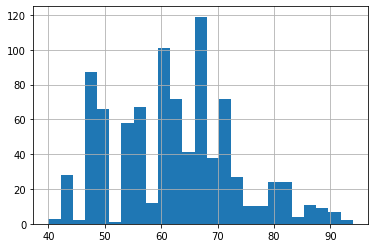

In [345]:
print(candidate.score.hist(bins=25))

In [315]:
candidate.score.describe()

count    895.000000
mean      62.375419
std       10.893108
min       40.000000
25%       54.000000
50%       63.000000
75%       69.000000
max       94.000000
Name: score, dtype: float64

In [13]:
def save_wireshark(df2_protocol,pkl_name,only_one=False):
    '''
    GOAL: save frame time list to pkl for Jerry to output wireshark pcap
    df2_protocol: protocol original dataframe (session-based)
    '''
    protocol_thr = df2_protocol.loc[big_dict_sqlmap[idx]]
    # protocol_thr = df2_protocol.loc[80891]  #也可只輸出一個特定sessiono的time frame list就好
    protocol_thr = protocol_thr.session_time_list.tolist()
    if not only_one:
        protocol_thr = [list(x) for x in protocol_thr]
    pickle.dump(obj=protocol_thr,file=open(pickle_dir+str(pkl_name)+'.pkl','wb'))
    print("總共具有的sessions數量:",len(protocol_thr))
# protocol_thr

sql map http

In [277]:
df2_http[df2_http.ip_src == '190.92.5.158'].index

Int64Index([   80890,    80891,    80892,   334327,   334328,   334329,
              334330,   334331,   334332,   334335,
            ...
            49785502, 50037370, 50037371, 50037372, 50290869, 50290870,
            50290871, 50290872, 50290873, 50290874],
           dtype='int64', length=819)

In [278]:
for k,v in big_dict_http.items():
    if 80891 in v:
        print(k)
        break

2394


In [279]:
case1_diagram = df2_http.loc[list(set(big_dict_http[2394]))]
time_lists = case1_diagram.session_time_list.tolist()
time_lists = [list(x) for x in time_lists]
ips = case1_diagram.ip_src.tolist()
countries = case1_diagram.country.tolist()
print(len(countries),len(ips))
# pickle_dir = '/home/antslab/spark_data/pcap_inter/2020_01_10/中華電信/case_pickles/'
pickle.dump(obj=(time_lists,ips,countries),file=open(pickle_dir+'case#1_threetuples.pkl','wb'))

905 905


In [280]:
case1_diagram.ip_src.unique()

array(['103.16.71.248', '117.1.16.131', '190.92.5.158', '109.198.110.234'],
      dtype=object)